## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
# Set plots style
plt.style.use('tableau-colorblind10')

## Load Topics Data

In [3]:
topics = pd.read_csv('data/topics_by_minute.csv')
topics = topics[['date', 'channel', 'minute', 'text', 'words_topic']]

# Filter out the 'tve' channel
topics = topics[topics['channel'] != 'tve']
topics.shape

(50124, 5)

In [4]:
# Assuming your dataframe is named df and the date column is named 'date_column'
topics['date'] = pd.to_datetime(topics['date'])

# Filter out observations for May 2024
topics = topics[~((topics['date'].dt.month == 5) & (topics['date'].dt.year == 2024))]
topics.shape

(48940, 5)

In [5]:
# Create the 'ukraine' column
topics['ukraine'] = topics['words_topic'].apply(lambda x: 1 if 'ucrania' in x else 0)

# Extract the month and year from the date column
topics['year_month'] = topics['date'].dt.to_period('M')

In [8]:
# Extract the month and year from the date column
topics['week'] = topics['date'].dt.to_period('W')

In [14]:
topics.date.min(), topics.date.max()

(Timestamp('2022-12-02 00:00:00'), Timestamp('2024-04-30 00:00:00'))

## Share of Time Speaking about the Russia-Ukraine War

In [12]:
# Group by year_month and channel, and count total records and records with 'ukraine' = 1
observations_by_month = topics.groupby(['channel', 'year_month']).agg(
    total_records=('date', 'size'),
    num_with_ukraine=('ukraine', 'sum')
).reset_index()

# Calculate the share of records mentioning 'ukraine'
observations_by_month['share_with_ukraine'] = observations_by_month['num_with_ukraine'] / observations_by_month['total_records']

# Convert 'year_month' to a datetime format
observations_by_month['year_month'] = observations_by_month['year_month'].dt.to_timestamp()

observations_by_month.head()

,channel,year_month,total_records,num_with_ukraine,share_with_ukraine
0,a3,2022-12-01,886,81,0.091422
1,a3,2023-01-01,1039,153,0.147257
2,a3,2023-02-01,935,183,0.195722
3,a3,2023-03-01,1027,115,0.111977
4,a3,2023-04-01,966,88,0.091097


In [13]:
# Group by week and channel, and count total records and records with 'ukraine' = 1
observations_by_week = topics.groupby(['channel', 'week']).agg(
    total_records=('date', 'size'),
    num_with_ukraine=('ukraine', 'sum')
).reset_index()

# Calculate the share of records mentioning 'ukraine'
observations_by_week['share_with_ukraine'] = observations_by_week['num_with_ukraine'] / observations_by_week['total_records']

# Convert 'year_month' to a datetime format
observations_by_week['week'] = observations_by_week['week'].dt.to_timestamp()

observations_by_week.head()

,channel,week,total_records,num_with_ukraine,share_with_ukraine
0,a3,2022-11-28,104,11,0.105769
1,a3,2022-12-05,231,19,0.082251
2,a3,2022-12-12,227,11,0.048458
3,a3,2022-12-19,200,23,0.115000
4,a3,2022-12-26,160,21,0.131250


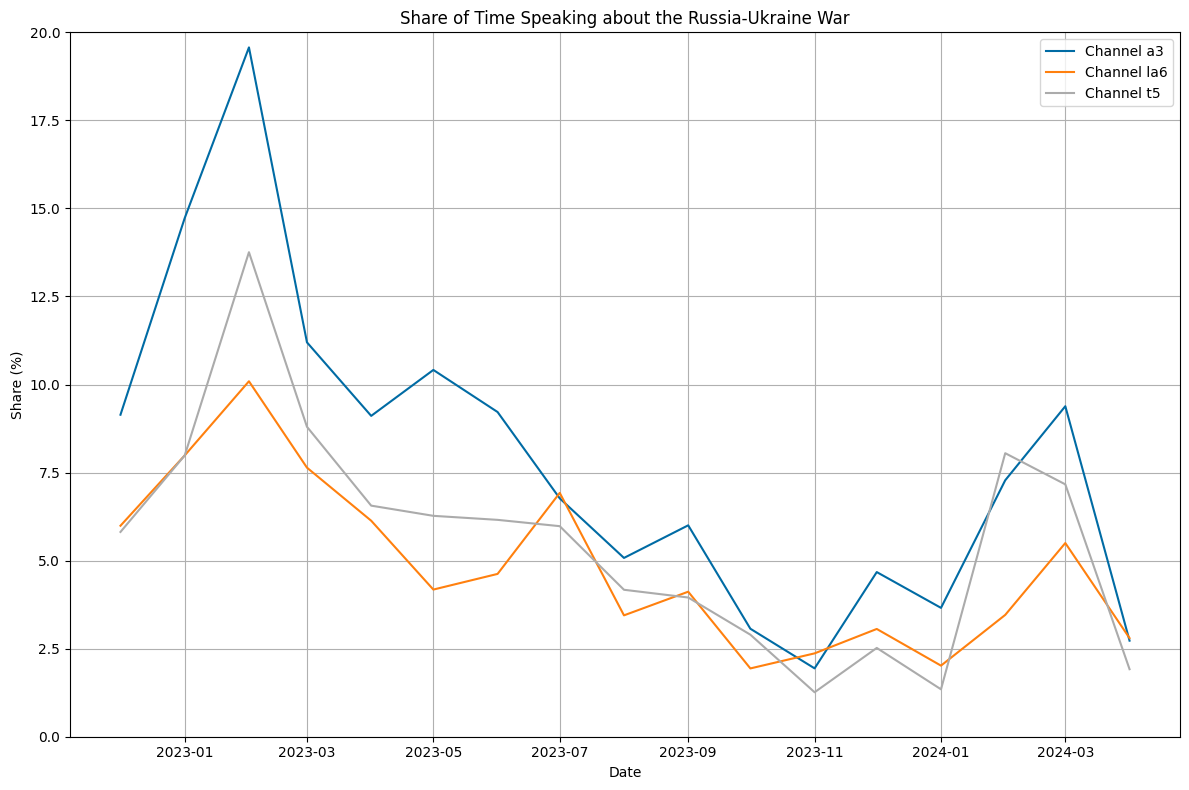

In [14]:
# Plotting
plt.figure(figsize=(12, 8))

channels = observations_by_month['channel'].unique()

for channel in channels:
    channel_data = observations_by_month[observations_by_month['channel'] == channel]
    plt.plot(channel_data['year_month'], channel_data['share_with_ukraine'] * 100, label=f'Channel {channel}')

plt.title('Share of Time Speaking about the Russia-Ukraine War')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.ylim(0, 20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

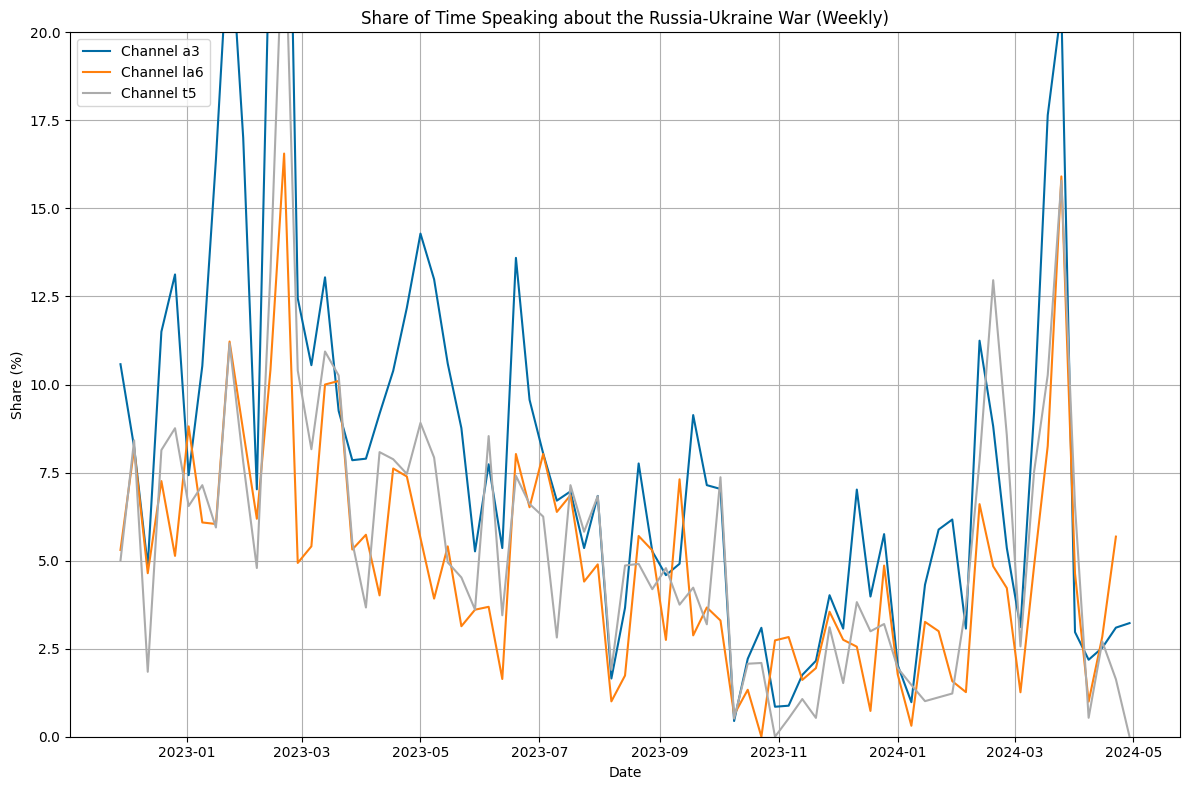

In [15]:
# Plotting
plt.figure(figsize=(12, 8))

channels_weekly = observations_by_week['channel'].unique()

for channel in channels_weekly:
    channel_data = observations_by_week[observations_by_week['channel'] == channel]
    plt.plot(channel_data['week'], channel_data['share_with_ukraine'] * 100, label=f'Channel {channel}')

plt.title('Share of Time Speaking about the Russia-Ukraine War (Weekly)')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.ylim(0, 20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

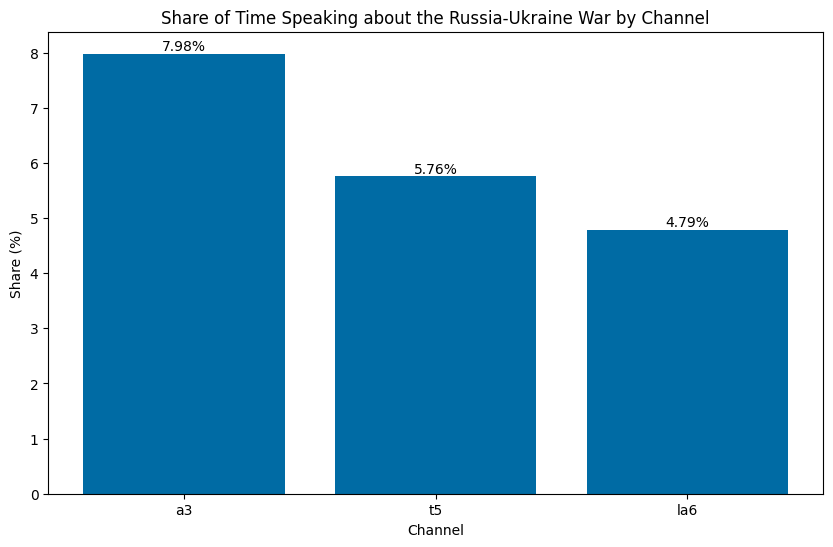

In [17]:
# Group by 'channel' and calculate the total 'total_records' and 'num_with_ukraine'
channel_summary = observations_by_month.groupby('channel').agg({
    'total_records': 'sum',
    'num_with_ukraine': 'sum'
}).reset_index()

# Calculate 'share_with_ukraine'
channel_summary['share_with_ukraine'] = channel_summary['num_with_ukraine'] / channel_summary['total_records']

# Sort the DataFrame by 'share_with_ukraine' in descending order
channel_summary = channel_summary.sort_values(by='share_with_ukraine', ascending=False)

# Convert 'share_with_ukraine' to percentages
channel_summary['share_with_ukraine'] = channel_summary['share_with_ukraine'] * 100

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(channel_summary['channel'], channel_summary['share_with_ukraine'])

# Add labels and title
plt.xlabel('Channel')
plt.ylabel('Share (%)')
plt.title('Share of Time Speaking about the Russia-Ukraine War by Channel')

# Add numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}%',
        ha='center',
        va='bottom'
    )

# Display the plot
plt.show()

## Restructure Topics Data for Future Use

In [21]:
# Convert 'year_month' to datetime format
observations_by_month['year_month'] = pd.to_datetime(observations_by_month['year_month'])

# Group by 'year_month' and aggregate
df_restructured = observations_by_month.groupby('year_month').agg(
    total_records=('total_records', 'sum'),
    num_with_ukraine=('num_with_ukraine', 'sum')
).reset_index()

# Calculate 'share_with_ukraine'
df_restructured['share_with_ukraine'] = df_restructured['num_with_ukraine'] / df_restructured['total_records']

# Sort by 'year_month'
df_restructured = df_restructured.sort_values(by='year_month')

# Make sure observations_by_month is also sorted
observations_by_month = observations_by_month.sort_values(by=['channel', 'year_month'])

# Add shares for each channel as a separate column
df_restructured['a3_share_with_ukraine'] = observations_by_month[observations_by_month.channel == 'a3'].reset_index()['share_with_ukraine']
df_restructured['la6_share_with_ukraine'] = observations_by_month[observations_by_month.channel == 'la6'].reset_index()['share_with_ukraine']
df_restructured['t5_share_with_ukraine'] = observations_by_month[observations_by_month.channel == 't5'].reset_index()['share_with_ukraine']
df_restructured.head()

,year_month,total_records,num_with_ukraine,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-12-01,2962,204,0.068872,0.091422,0.059908,0.058140
1,2023-01-01,3155,322,0.102060,0.147257,0.079872,0.079861
2,2023-02-01,2989,422,0.141184,0.195722,0.100925,0.137572
3,2023-03-01,3224,293,0.090881,0.111977,0.076399,0.088000
4,2023-04-01,2963,214,0.072224,0.091097,0.061329,0.065614


In [22]:
# Convert 'year_month' to datetime format
observations_by_week['week'] = pd.to_datetime(observations_by_week['week'])

# Group by 'year_month' and aggregate
df_restructured_weekly = observations_by_week.groupby('week').agg(
    total_records=('total_records', 'sum'),
    num_with_ukraine=('num_with_ukraine', 'sum')
).reset_index()

# Calculate 'share_with_ukraine'
df_restructured_weekly['share_with_ukraine'] = df_restructured_weekly['num_with_ukraine'] / df_restructured_weekly['total_records']

# Sort by 'year_month'
df_restructured_weekly = df_restructured_weekly.sort_values(by='week')

# Make sure observations_by_month is also sorted
observations_by_week = observations_by_week.sort_values(by=['channel', 'week'])

# Add shares for each channel as a separate column
df_restructured_weekly['a3_share_with_ukraine'] = observations_by_week[observations_by_week.channel == 'a3'].reset_index()['share_with_ukraine']
df_restructured_weekly['la6_share_with_ukraine'] = observations_by_week[observations_by_week.channel == 'la6'].reset_index()['share_with_ukraine']
df_restructured_weekly['t5_share_with_ukraine'] = observations_by_week[observations_by_week.channel == 't5'].reset_index()['share_with_ukraine']
df_restructured_weekly.head()

,week,total_records,num_with_ukraine,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-11-28,316,22,0.069620,0.105769,0.053030,0.050000
1,2022-12-05,751,62,0.082557,0.082251,0.081761,0.084158
2,2022-12-12,724,28,0.038674,0.048458,0.046429,0.018433
3,2022-12-19,620,55,0.088710,0.115000,0.072581,0.081395
4,2022-12-26,667,52,0.077961,0.131250,0.051351,0.087591


## Explore Missing Data

### Number of Missing Transcrips (Number of Missing Dates in the Topics File)

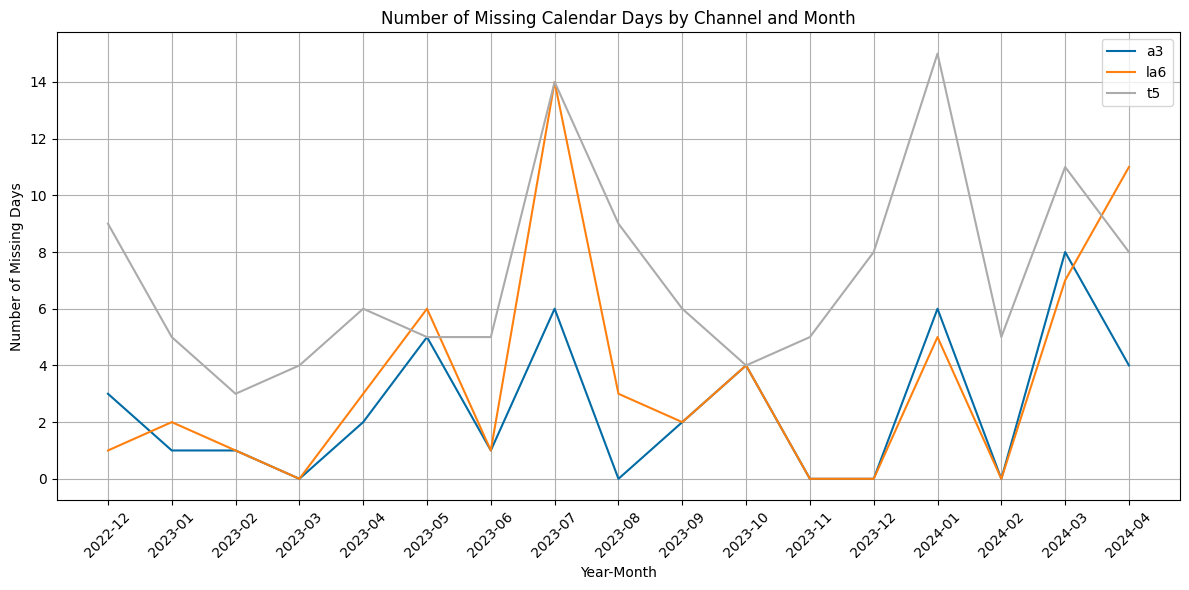

In [13]:
import calendar

# Group by 'channel' and 'year_month' and count unique days
grouped = topics.groupby(['channel', 'year_month'])['date'].nunique().reset_index()
grouped = grouped.rename(columns={'date': 'unique_days'})

# Calculate the number of days in each month
grouped['days_in_month'] = grouped['year_month'].apply(lambda x: calendar.monthrange(x.year, x.month)[1])

# Calculate missing days
grouped['missing_days'] = grouped['days_in_month'] - grouped['unique_days']

# Plot the missing days
plt.figure(figsize=(12, 6))
for channel in grouped['channel'].unique():
    channel_data = grouped[grouped['channel'] == channel]
    plt.plot(channel_data['year_month'].astype(str), channel_data['missing_days'], label=channel)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Missing Days')
plt.title('Number of Missing Calendar Days by Channel and Month')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

### Number of Missing Videos

(out of those present in the topics file, the Russia-Ukraine War topic only)

! DO NOT RUN THIS SECTION

In [42]:
folder = 'data/frames'
subfolders = ['atres', 'la6', 'telecinco']

# Dictionary to store the list of files for each subfolder
files_in_subfolders = {}

# Iterate through each subfolder and get the list of files
for subfolder in subfolders:
    subfolder_path = os.path.join(folder, subfolder)
    # List all files in the subfolder
    files = os.listdir(subfolder_path)
    files_in_subfolders[subfolder] = files

atres_files = files_in_subfolders['atres']
la6_files = files_in_subfolders['la6']
telecinco_files = files_in_subfolders['telecinco']

print(len(atres_files))
print(len(la6_files))
print(len(telecinco_files))

48039
57931
46237


In [44]:
# Function to filter files that end with .jpg
def filter_jpg_files(file_list):
    if file_list is not None:
        return [file for file in file_list if file.endswith('.jpg')]
    return []

# Filter .jpg files in each subfolder
atres_files_jpg = filter_jpg_files(files_in_subfolders['atres'])
la6_files_jpg = filter_jpg_files(files_in_subfolders['la6'])
telecinco_files_jpg = filter_jpg_files(files_in_subfolders['telecinco'])

print(len(atres_files_jpg))
print(len(la6_files_jpg))
print(len(telecinco_files_jpg))

48038
57928
46236


In [49]:
atres_dates = list(set([name.split('_')[3] for name in atres_files_jpg]))
la6_dates = list(set([name.split('_')[3] for name in la6_files_jpg]))
t5_dates = list(set([name.split('_')[3] for name in telecinco_files_jpg]))

# Num of unique dates in the folder
len(atres_dates), len(la6_dates), len(t5_dates)

(304, 310, 294)

In [48]:
# Filter the DataFrame
topics_ua = topics[topics['words_topic'].apply(lambda x: 'ucrania' in x)]
print(topics_ua.shape)

a3_df = topics_ua[topics_ua.channel == 'a3']
la6_df = topics_ua[topics_ua.channel == 'la6']
t5_df = topics_ua[topics_ua.channel == 't5']

a3_dates_topics = a3_df.date.unique()
la6_dates_topics = la6_df.date.unique()
t5_dates_topics = t5_df.date.unique()

# Num of unique dates in the topics file
len(a3_dates_topics), len(la6_dates_topics), len(t5_dates_topics)

(2964, 7)


(393, 318, 281)

In [50]:
# Convert string dates to datetime
atres_dates_dt = pd.to_datetime(atres_dates)
la6_dates_dt = pd.to_datetime(la6_dates)
t5_dates_dt = pd.to_datetime(t5_dates)

# Find dates in a3_dates_topics not in atres_dates_dt
a3_diff = [date for date in a3_dates_topics if date not in atres_dates_dt]

# Find dates in la6_dates_topics not in la6_dates_dt
la6_diff = [date for date in la6_dates_topics if date not in la6_dates_dt]

# Find dates in t5_dates_topics not in t5_dates_dt
t5_diff = [date for date in t5_dates_topics if date not in t5_dates_dt]

len(a3_diff), len(la6_diff), len(t5_diff)

(104, 8, 0)

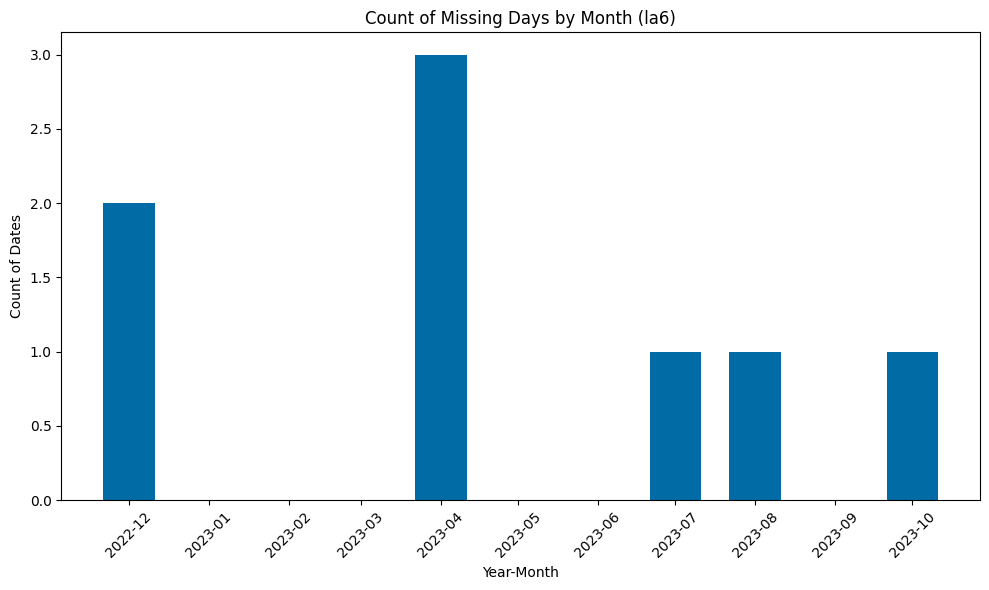

In [72]:
# Convert the list to a DataFrame
la6_df = pd.DataFrame(la6_diff, columns=['date'])

# Extract year and month
la6_df['year_month'] = la6_df['date'].dt.to_period('M')

# Group by year and month and count the occurrences
la6_missing_by_month = la6_df['year_month'].value_counts().sort_index()

# Convert the list to a DataFrame
la6_df = pd.DataFrame(la6_diff, columns=['date'])

# Extract year and month
la6_df['year_month'] = la6_df['date'].dt.to_period('M')

# Convert the Series to a DataFrame
la6_missing_by_month = la6_missing_by_month.reset_index()
la6_missing_by_month.columns = ['year_month', 'count']

# Convert 'year_month' to timestamp for plotting
la6_missing_by_month['year_month'] = la6_missing_by_month['year_month'].dt.to_timestamp()

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(la6_missing_by_month['year_month'], la6_missing_by_month['count'], width=20)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Count of Dates')
plt.title('Count of Missing Days by Month (la6)')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

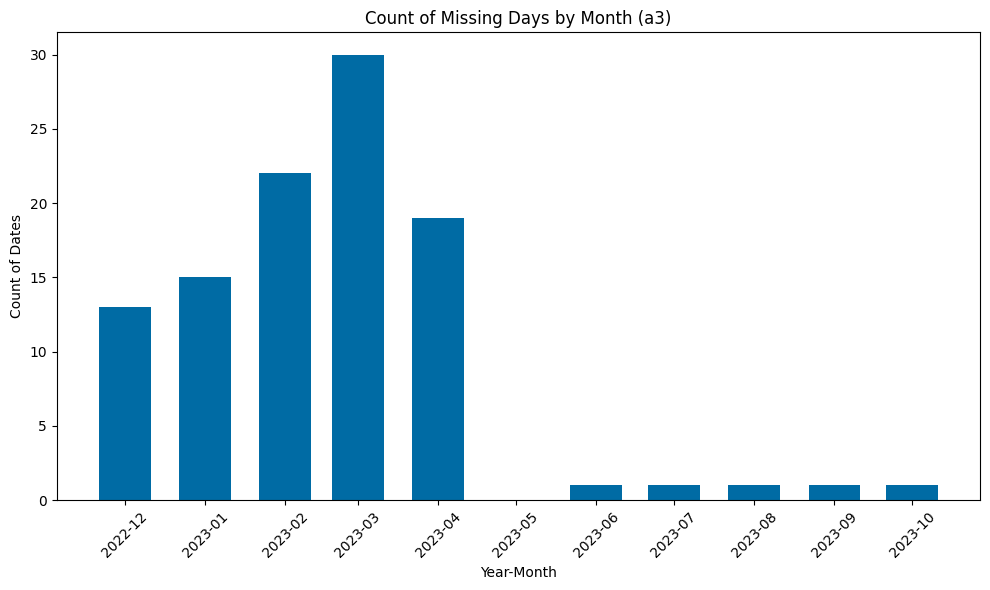

In [73]:
# Convert the list to a DataFrame
a3_df = pd.DataFrame(a3_diff, columns=['date'])

# Extract year and month
a3_df['year_month'] = a3_df['date'].dt.to_period('M')

# Group by year and month and count the occurrences
a3_missing_by_month = a3_df['year_month'].value_counts().sort_index()

# Convert the list to a DataFrame
a3_df = pd.DataFrame(a3_diff, columns=['date'])

# Extract year and month
a3_df['year_month'] = a3_df['date'].dt.to_period('M')

# Convert the Series to a DataFrame
a3_missing_by_month = a3_missing_by_month.reset_index()
a3_missing_by_month.columns = ['year_month', 'count']

# Convert 'year_month' to timestamp for plotting
a3_missing_by_month['year_month'] = a3_missing_by_month['year_month'].dt.to_timestamp()

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(a3_missing_by_month['year_month'], a3_missing_by_month['count'], width=20)

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Count of Dates')
plt.title('Count of Missing Days by Month (a3)')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Load Additional Data

### Massive Missile Attacks on Ukraine

In [17]:
# Load data
df_missiles_daily = pd.read_csv('additional_data/missile_attacks/missile_attacks_daily.csv')
df_missiles_description = pd.read_csv('additional_data/missile_attacks/missiles_and_uav.csv')
df_missiles = df_missiles_daily.merge(df_missiles_description, how='left', on=['model'])
print(df_missiles.shape)
display(df_missiles)

(1167, 21)


,time_start,time_end,model,launch_place,target,destroyed_details,carrier,launched,destroyed,source,...,national_origin,type,launch_platform,name,name_NATO,guidance_system,features,unit_cost,produced,manufacturer
0,2024-06-08,2024-06-08 08:00,X-59,Kursk oblast,east,NaN,NaN,1.0,1,kpszsu/posts/pfbid0ura4yLKn4kKnbnW6WeNqaTWiasN...,...,russia,air-to-surface,"Su-30MK, Su-24M, MiG-27, Su-17M3/22M4, HAL Tej...",Kh-59 Ovod,AS-13 'Kingbolt',NaN,NaN,NaN,NaN,NaN
1,2024-06-08,2024-06-08 08:00,Supercam,NaN,east,NaN,NaN,2.0,2,pvkshid/posts/pfbid02x9v3uZxSB3TgdedK5kF7DyNPN...,...,russia,reconnaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmanned Systems Group
2,2024-06-08,2024-06-08 08:00,Shahed-136/131,"Chauda, Crimea and Kursk oblast",Ukraine,"{'Poltava oblast': 1, 'Kharkiv oblast': NaN, '...",NaN,13.0,9,kpszsu/posts/pfbid0ura4yLKn4kKnbnW6WeNqaTWiasN...,...,iran,loitering munition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shahed Aviation Industries
3,2024-06-08,2024-06-08,Lancet,NaN,Kherson oblast,NaN,NaN,4.0,4,PvKPivden/posts/pfbid02GLn4kq7vQfjLQD4vaKycwQD...,...,russia,loitering munition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZALA Aero Group
4,2024-06-07,2024-06-07 08:00,X-101/X-555,Saratov oblast,west,NaN,Tu-95MS,5.0,5,kpszsu/posts/pfbid0zAYzn1GoGTtWFRi283Z8pnCJKZJ...,...,russia,air-launched,"Tu-95MS, Tu-160, Su-34",Kh-101/Kh-555,Kent-C,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,2022-10-01 12:00,2022-10-01 12:00,Orlan-10,NaN,Ukraine,NaN,NaN,1.0,1,watch/?v=375517448001233,...,russia,reconnaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Special Technology Center
1163,2022-09-30,2022-09-30,Orlan-10,NaN,Ukraine,NaN,NaN,3.0,3,kpszsu/posts/pfbid0nELeXY4BpHrezv54Lk3gWPZJmcC...,...,russia,reconnaissance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Special Technology Center
1164,2022-09-29 23:00,2022-09-29 23:59,Shahed-136/131,NaN,Odesa oblast and Mykolaiv oblast,NaN,NaN,7.0,5,kpszsu/posts/pfbid021aK2TqryAuB8gGrDYMTv3R8Xiu...,...,iran,loitering munition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shahed Aviation Industries
1165,2022-09-28,2022-09-28,X-59,NaN,Dnipropetrovsk oblast and Zaporizhzhia oblast,NaN,Su-35,5.0,4,kpszsu/posts/pfbid02sjn5m7kosAfsm5bSUzpPwbLuH3...,...,russia,air-to-surface,"Su-30MK, Su-24M, MiG-27, Su-17M3/22M4, HAL Tej...",Kh-59 Ovod,AS-13 'Kingbolt',NaN,NaN,NaN,NaN,NaN


In [18]:
# Convert 'time_start' to datetime format using the mixed format
df_missiles['time_start'] = pd.to_datetime(df_missiles['time_start'], format='mixed')

# Extract month and year
df_missiles['year_month'] = df_missiles['time_start'].dt.to_period('M')
df_missiles['week'] = df_missiles['time_start'].dt.to_period('W')

# Group by month and year and sum 'launched'
df_aggregated = df_missiles.groupby('year_month')['launched'].sum().reset_index()

# Convert 'month_year' back to a datetime format for easier reading (optional)
df_aggregated['year_month'] = df_aggregated['year_month'].dt.to_timestamp()

# Rename columns for clarity
# df_aggregated.columns = ['Month', 'Total_Launched']

# Filter the DataFrame to include only months from 2022-12 to 2024-04
start_date = pd.Timestamp('2022-12-01')
end_date = pd.Timestamp('2024-04-30')
df_aggregated = df_aggregated[(df_aggregated['year_month'] >= start_date) & (df_aggregated['year_month'] <= end_date)]

In [19]:
df_aggregated_weekly = df_missiles.groupby('week')['launched'].sum().reset_index()
# Convert 'week' back to a datetime format for easier reading (optional)
df_aggregated_weekly['week'] = df_aggregated_weekly['week'].dt.to_timestamp()

# Filter the DataFrame to include only months from 2022-12 to 2024-04
start_date = pd.Timestamp('2022-12-01')
end_date = pd.Timestamp('2024-04-30')
df_aggregated_weekly = df_aggregated_weekly[(df_aggregated_weekly['week'] >= start_date) & (df_aggregated_weekly['week'] <= end_date)]

In [23]:
# Merge df_aggregated with df_restructured on 'Month' and 'year_month'
df_aggregated = pd.merge(df_aggregated, df_restructured[['year_month', 
                                                         'share_with_ukraine',
                                                        'a3_share_with_ukraine',
                                                        'la6_share_with_ukraine',
                                                        't5_share_with_ukraine']], on='year_month', how='left')
df_aggregated.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614


In [24]:
# Merge df_aggregated with df_restructured on 'Month' and 'week'
df_aggregated_weekly = pd.merge(df_aggregated_weekly, df_restructured_weekly[['week', 
                                                         'share_with_ukraine',
                                                        'a3_share_with_ukraine',
                                                        'la6_share_with_ukraine',
                                                        't5_share_with_ukraine']], on='week', how='left')
df_aggregated_weekly.head()

,week,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine
0,2022-12-05,99.0,0.082557,0.082251,0.081761,0.084158
1,2022-12-12,116.0,0.038674,0.048458,0.046429,0.018433
2,2022-12-19,38.0,0.088710,0.115000,0.072581,0.081395
3,2022-12-26,156.0,0.077961,0.131250,0.051351,0.087591
4,2023-01-02,41.0,0.076590,0.074257,0.088123,0.065502


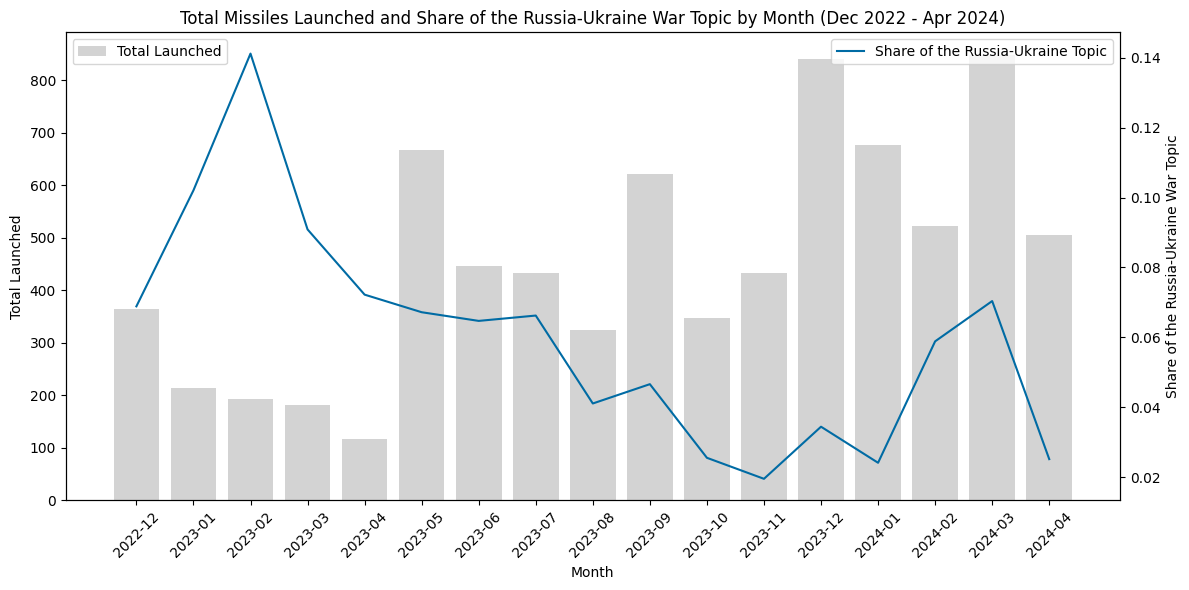

In [25]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['launched'], color='lightgrey', label='Total Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['share_with_ukraine'], label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

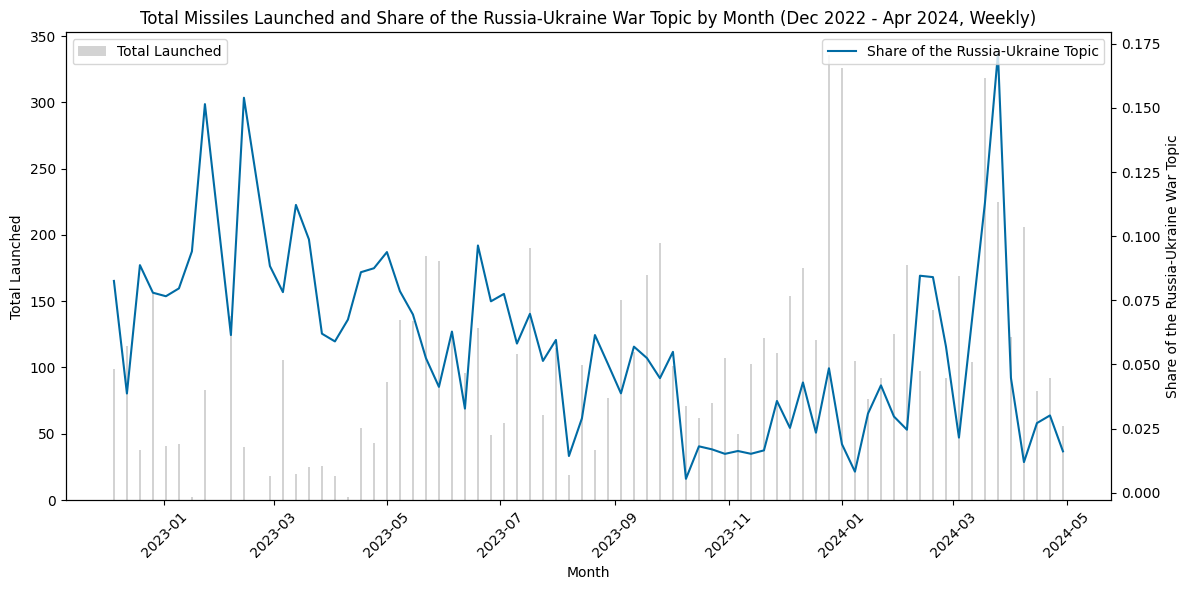

In [27]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(df_aggregated_weekly['week'], df_aggregated_weekly['launched'], color='lightgrey', label='Total Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(df_aggregated_weekly['week'], df_aggregated_weekly['share_with_ukraine'], label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024, Weekly)')
plt.tight_layout()
plt.show()

### Number of Fatalities

In [28]:
fatalities = pd.read_csv('additional_data/number_of_fatalities/2022-12-01-2024-05-13-Europe-Ukraine.csv')
fatalities.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,UKR158104,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Zmiyinyy Island,45.2549,30.2037,1,Institute for the Study of War,Other,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715125698
1,UKR158083,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Baranivka,51.9219,34.1846,2,Ministry of Defence of Ukraine; Suspilne Media,Other-National,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715131178
2,UKR158084,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Bohoiavlenka,47.8601,37.2135,2,Ministry of Defence of Ukraine,Other,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715131178
3,UKR158085,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Borova,49.3777,37.6214,2,Ministry of Defence of Ukraine,Other,"On 3 May 2024, Russian Forces launched air str...",0,NaN,1715131178
4,UKR158086,03 May 2024,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Russia (2000-) Air Force,NaN,8,...,Chasiv Yar,48.5869,37.8324,1,Novoye Vremya Ukraine; Suspilne Media,National,"On 3 May 2024, Russian Forces launched FPV-dro...",1,NaN,1715131178


In [29]:
# Convert 'event_date' to datetime format (adjusting format to handle full month names)
fatalities['event_date'] = pd.to_datetime(fatalities['event_date'], format="%d %B %Y")

# Filter to include only months from December 2022 to April 2024
start_date = pd.Timestamp('2022-12-01')
end_date = pd.Timestamp('2024-04-30')
fatalities_filtered = fatalities[(fatalities['event_date'] >= start_date) & (fatalities['event_date'] <= end_date)]

# Group by month and sum the fatalities
fatalities_filtered['year_month'] = fatalities_filtered['event_date'].dt.to_period('M')
fatalities_filtered['week'] = fatalities_filtered['event_date'].dt.to_period('W')

fatalities_by_month = fatalities_filtered.groupby('year_month')['fatalities'].sum().reset_index()
fatalities_by_week = fatalities_filtered.groupby('week')['fatalities'].sum().reset_index()

# Convert 'month_year' back to a datetime format for easier reading (optional)
fatalities_by_month['year_month'] = fatalities_by_month['year_month'].dt.to_timestamp()
fatalities_by_week['week'] = fatalities_by_week['week'].dt.to_timestamp()

/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_55066/2348508956.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatalities_filtered['year_month'] = fatalities_filtered['event_date'].dt.to_period('M')
/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_55066/2348508956.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatalities_filtered['week'] = fatalities_filtered['event_date'].dt.to_period('W')


In [30]:
# Merge df_aggregated with df_restructured on 'Month' and 'year_month'
df_aggregated = pd.merge(df_aggregated, fatalities_by_month, on='year_month', how='left')
df_aggregated.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140,2174
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861,1187
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572,665
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000,866
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614,1135


In [31]:
# Merge df_aggregated with df_restructured on 'Month' and 'year_month'
df_aggregated_weekly = pd.merge(df_aggregated_weekly, fatalities_by_week, on='week', how='left')
df_aggregated_weekly.head()

,week,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities
0,2022-12-05,99.0,0.082557,0.082251,0.081761,0.084158,313
1,2022-12-12,116.0,0.038674,0.048458,0.046429,0.018433,282
2,2022-12-19,38.0,0.088710,0.115000,0.072581,0.081395,646
3,2022-12-26,156.0,0.077961,0.131250,0.051351,0.087591,972
4,2023-01-02,41.0,0.076590,0.074257,0.088123,0.065502,211


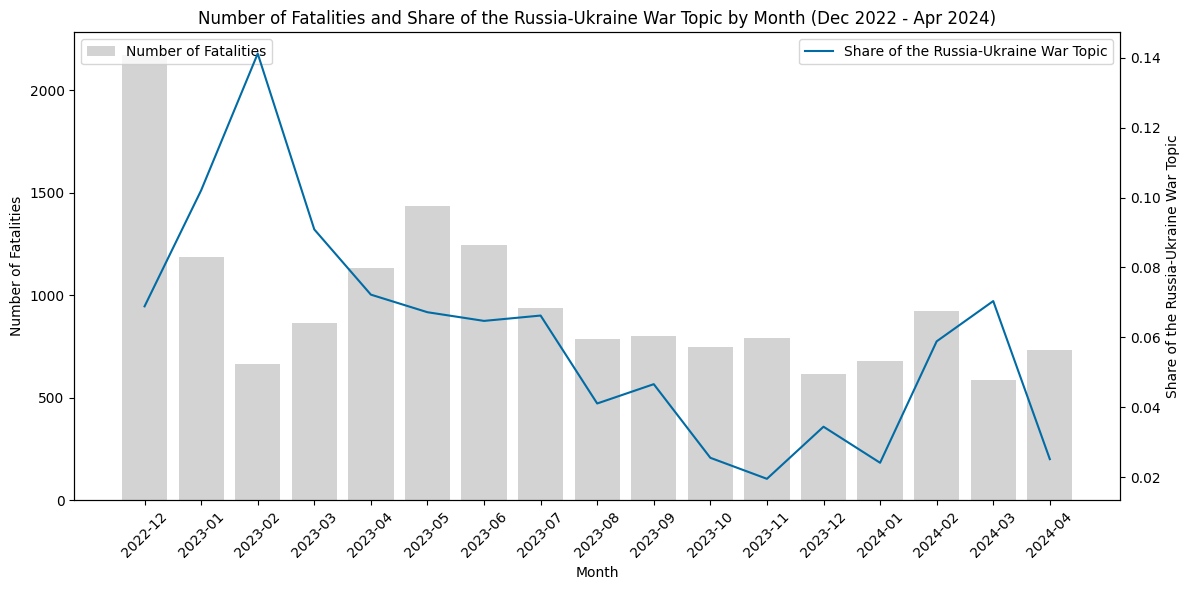

In [32]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['fatalities'], color='lightgrey', label='Number of Fatalities')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Fatalities')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(df_aggregated['year_month'].dt.strftime('%Y-%m'), df_aggregated['share_with_ukraine'],  label='Share of the Russia-Ukraine War Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')
ax2.legend(loc='upper right')

plt.title('Number of Fatalities and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

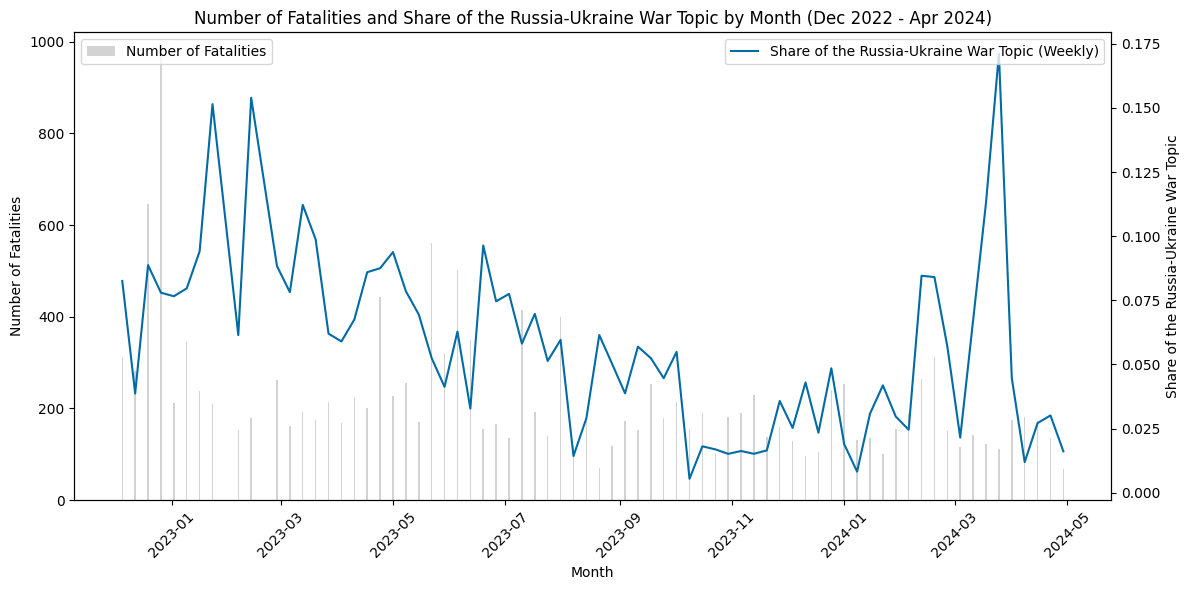

In [35]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(df_aggregated_weekly['week'], df_aggregated_weekly['fatalities'], color='lightgrey', label='Number of Fatalities')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Fatalities')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(df_aggregated_weekly['week'], df_aggregated_weekly['share_with_ukraine'],  label='Share of the Russia-Ukraine War Topic (Weekly)')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')
ax2.legend(loc='upper right')

plt.title('Number of Fatalities and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

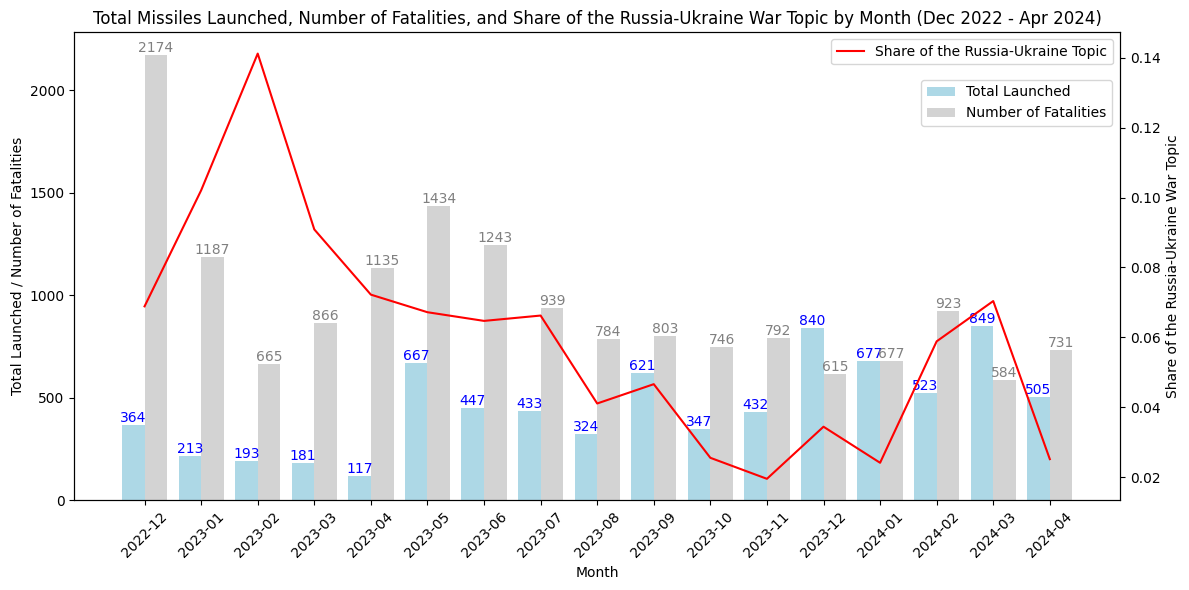

In [45]:
# Plotting missiles launched and fatalities together with share of war coverage

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Plot the second bar chart (Number of Fatalities)
bars2 = ax1.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched / Number of Fatalities')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create a second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(r1 + bar_width / 2, df_aggregated['share_with_ukraine'], color='r', label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of the Russia-Ukraine War Topic')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.81, 0.8))
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()


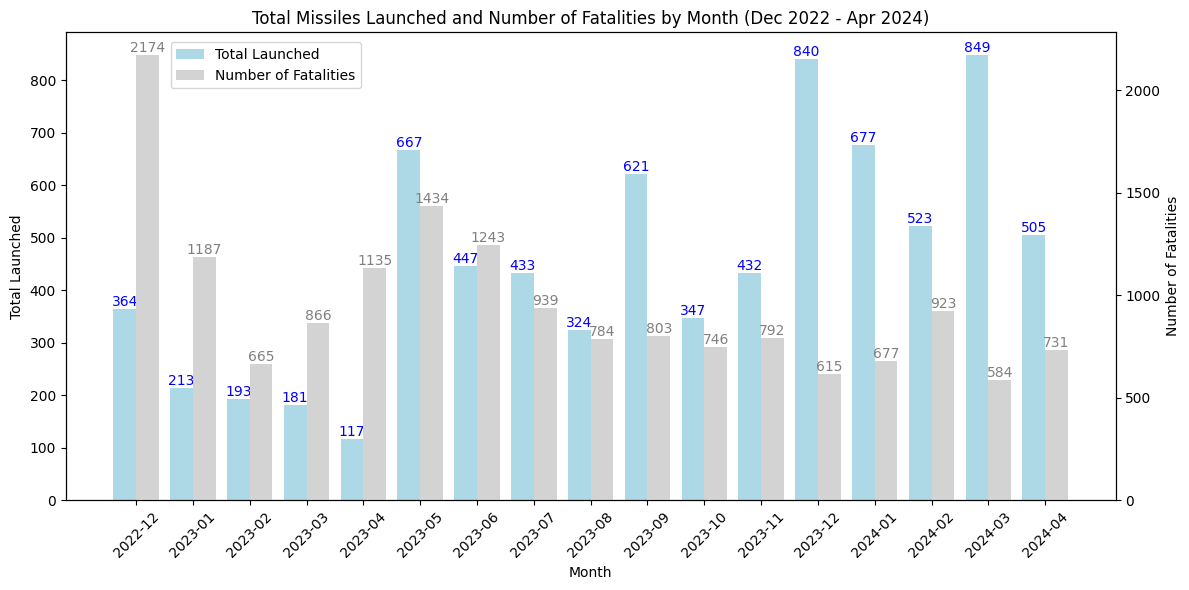

In [68]:
# Plotting fatalities and total launched together on different scales
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Add labels and title for ax1
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create a second y-axis for the Number of Fatalities
ax2 = ax1.twinx()
bars2 = ax2.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels for ax2
ax2.set_ylabel('Number of Fatalities')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.1, 0.88))
#ax2.legend(loc='upper right')

plt.title('Total Missiles Launched and Number of Fatalities by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()


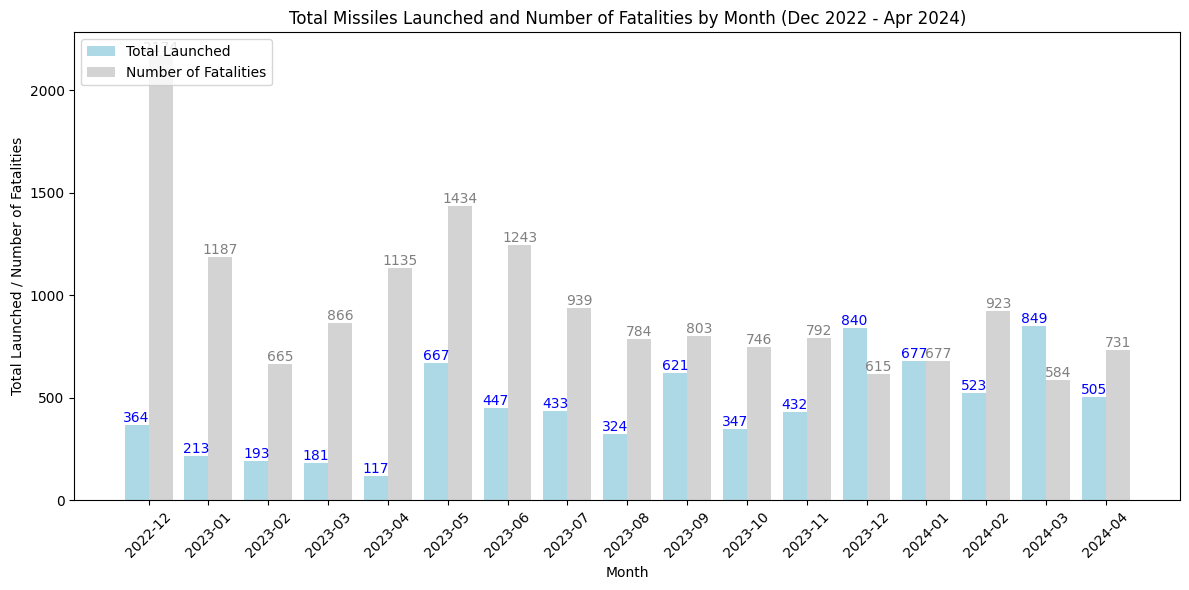

In [69]:
# Plotting fatalities and misslies launched on same scale

# Assuming df_aggregated is already defined DataFrame

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Plot the second bar chart (Number of Fatalities)
bars2 = ax1.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched / Number of Fatalities')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc='upper left')

plt.title('Total Missiles Launched and Number of Fatalities by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

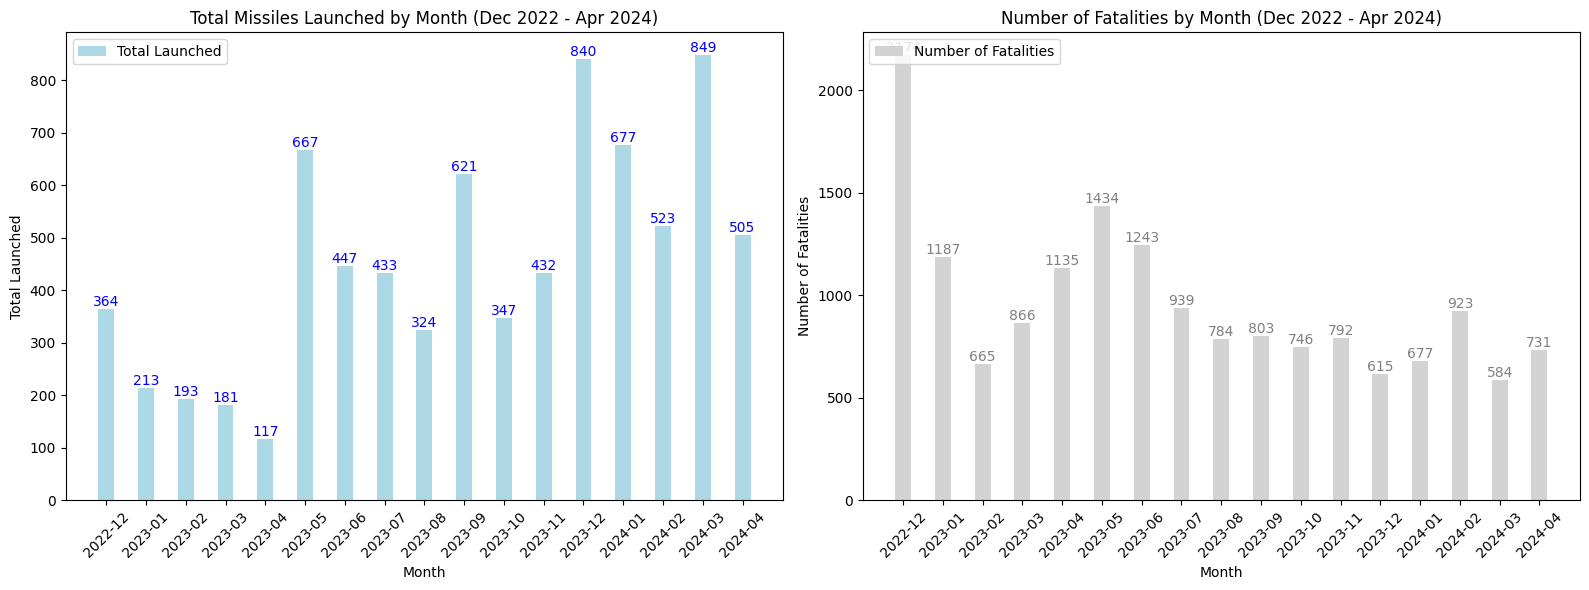

In [74]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)

# Plot the first bar chart (Total Launched) on ax1
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched')
ax1.set_title('Total Missiles Launched by Month (Dec 2022 - Apr 2024)')
ax1.set_xticks(r1)
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)
ax1.legend(loc='upper left')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Plot the second bar chart (Number of Fatalities) on ax2
bars2 = ax2.bar(r1, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Fatalities')
ax2.set_title('Number of Fatalities by Month (Dec 2022 - Apr 2024)')
ax2.set_xticks(r1)
ax2.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)
ax2.legend(loc='upper left')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

plt.tight_layout()
plt.show()

## Predictions on Entire Dataset

In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import torchvision
# import numpy as np
# from typing import List
# import os
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# from torchvision.io import read_image
# from torchvision import transforms, models
# from torch.utils.data import random_split
# from torchvision.transforms.functional import to_pil_image
# import torch.optim as optim
# from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# from tqdm import tqdm
# import torch.nn.functional as F

In [21]:
# resnet50 = torchvision.models.resnet50(weights=("pretrained", models.ResNet50_Weights.IMAGENET1K_V1))

# # Freeze all the parameters
# for param in resnet50.parameters():
#     param.requires_grad = False

# # Replace the final fully connected layer
# num_ftrs = resnet50.fc.in_features
# # Define the custom head with two additional dense layers
# resnet50.fc = torch.nn.Sequential(
#     torch.nn.Linear(num_ftrs, 512),
#     torch.nn.ReLU(),
#     # torch.nn.Dropout(0.5),  # Optional dropout for regularization
#     torch.nn.Linear(512, 256),
#     torch.nn.ReLU(),
#     # torch.nn.Dropout(0.5),  # Optional dropout for regularization
#     torch.nn.Linear(256, 1)
# )

# # Move the model to the GPU if available
# device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# resnet50 = resnet50.to(device)

In [22]:
# # Load the weights
# saved_weights_path = '/Users/viktoriia/Desktop/thesis/pytorch/model_weights/resnet50_TL-L4.pth'
# resnet50.load_state_dict(torch.load(saved_weights_path, map_location=device))

In [23]:
# class UnlabeledImageDataset(torch.utils.data.Dataset):
#     def __init__(self, img_dir, transform=None):
#         self.img_dir = img_dir
#         # self.img_paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]
#         self.img_paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir) if img.lower().endswith(('jpeg', 'jpg', 'png', 'gif'))]
#         self.transform = transform

#     def __len__(self):
#         return len(self.img_paths)

#     def __getitem__(self, idx):
#         img_path = self.img_paths[idx]
#         image = read_image(img_path)
        
#         # Convert tensor to PIL image
#         image = to_pil_image(image)

#         if self.transform:
#             image = self.transform(image)

#         return image, img_path  # Return image and its path


# # Use same transformations as before
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
# ])

In [24]:
# # Create data loader
# img_dir = '/Users/viktoriia/Desktop/thesis/data/frames/la6'
# unlabeled_dataset = UnlabeledImageDataset(img_dir, transform=transform)
# unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

In [25]:
# def predict_unlabeled_images(model, dataloader):
#     model.eval()
#     all_probs = []
#     all_img_paths = []

#     with torch.no_grad():  # Disable gradient calculation for evaluation
#         for inputs, img_paths in tqdm(dataloader, desc="Predicting", unit="batch"):
#             inputs = inputs.to(device)
            
#             outputs = model(inputs)
#             probs = torch.sigmoid(outputs)
            
#             all_probs.extend(probs)
#             all_img_paths.extend(img_paths)
    
#     return all_img_paths, all_probs

In [26]:
# # Make predictions
# img_paths, predictions = predict_unlabeled_images(resnet50, unlabeled_dataloader)

In [27]:
# # Convert the list of tensors to a list of floats
# predictions = [pred.item() for pred in predictions]

# threshold = 0.6
# binary_predictions = [1 if pred > threshold else 0 for pred in predictions]

# # Create a DataFrame
# df = pd.DataFrame({
#     'filename': img_paths,
#     'predicted_class': binary_predictions
# })

# #TODO: convert to a dataframe
# df['date'] = df['filename'].apply(lambda x: x.split('_')[3])

In [28]:
# # Step 1: Convert the 'date' column to datetime format
# df['date'] = pd.to_datetime(df['date'])

# # Step 2: Extract month and year
# df['year_month'] = df['date'].dt.to_period('M')

# # Group by year-month and calculate the share of class 1.0 observations
# share_class_1 = df.groupby('year_month')['predicted_class'].mean().reset_index()
# share_class_1

# # Rename the column for better clarity
# share_class_1 = share_class_1.rename(columns={'predicted_class': 'la6_share_class_1'})

# # Convert 'month_year' back to a datetime format for easier reading (optional)
# share_class_1['year_month'] = share_class_1['year_month'].dt.to_timestamp()

In [29]:
# df.to_csv('./la6_predictions.csv', index=False)
# share_class_1.to_csv('./la6_predictions_agg.csv', index=False)

In [36]:
# Load Predictions

a3_predictions = pd.read_csv('predictions/atres_predictions.csv')
a3_predictions['channel'] = 'a3'

la6_predictions = pd.read_csv('predictions/la6_predictions.csv')
la6_predictions['channel'] = 'la6'

t5_predictions = pd.read_csv('predictions/telecinco_predictions.csv')
t5_predictions['channel'] = 't5'

# Convert the 'date' column to datetime format
a3_predictions['date'] = pd.to_datetime(a3_predictions['date'])
la6_predictions['date'] = pd.to_datetime(la6_predictions['date'])
t5_predictions['date'] = pd.to_datetime(t5_predictions['date'])

# Extract month and year
a3_predictions['year_month'] = a3_predictions['date'].dt.to_period('M')
la6_predictions['year_month'] = la6_predictions['date'].dt.to_period('M')
t5_predictions['year_month'] = t5_predictions['date'].dt.to_period('M')

a3_predictions['week'] = a3_predictions['date'].dt.to_period('W')
la6_predictions['week'] = la6_predictions['date'].dt.to_period('W')
t5_predictions['week'] = t5_predictions['date'].dt.to_period('W')

combined_predictions = pd.concat([a3_predictions, la6_predictions, t5_predictions])

In [37]:
# Group by year-month and calculate the share of class 1.0 observations
a3_share_class_1 = a3_predictions.groupby('year_month')['predicted_class'].mean().reset_index()
la6_share_class_1 = la6_predictions.groupby('year_month')['predicted_class'].mean().reset_index()
t5_share_class_1 = t5_predictions.groupby('year_month')['predicted_class'].mean().reset_index()
combined_share_class_1 = combined_predictions.groupby('year_month')['predicted_class'].mean().reset_index()

# Rename the column for better clarity
a3_share_class_1 = a3_share_class_1.rename(columns={'predicted_class': 'a3_share_class_1'})
la6_share_class_1 = la6_share_class_1.rename(columns={'predicted_class': 'la6_share_class_1'})
t5_share_class_1 = t5_share_class_1.rename(columns={'predicted_class': 't5_share_class_1'})
combined_share_class_1 = combined_share_class_1.rename(columns={'predicted_class': 'total_share_class_1'})

# Convert 'month_year' back to a datetime format for easier reading (optional)
a3_share_class_1['year_month'] = a3_share_class_1['year_month'].dt.to_timestamp()
la6_share_class_1['year_month'] = la6_share_class_1['year_month'].dt.to_timestamp()
t5_share_class_1['year_month'] = t5_share_class_1['year_month'].dt.to_timestamp()
combined_share_class_1['year_month'] = combined_share_class_1['year_month'].dt.to_timestamp()

In [38]:
# Group by week and calculate the share of class 1.0 observations
a3_share_class_1_weekly = a3_predictions.groupby('week')['predicted_class'].mean().reset_index()
la6_share_class_1_weekly = la6_predictions.groupby('week')['predicted_class'].mean().reset_index()
t5_share_class_1_weekly = t5_predictions.groupby('week')['predicted_class'].mean().reset_index()
combined_share_class_1_weekly = combined_predictions.groupby('week')['predicted_class'].mean().reset_index()

# Rename the column for better clarity
a3_share_class_1_weekly = a3_share_class_1_weekly.rename(columns={'predicted_class': 'a3_share_class_1'})
la6_share_class_1_weekly = la6_share_class_1_weekly.rename(columns={'predicted_class': 'la6_share_class_1'})
t5_share_class_1_weekly = t5_share_class_1_weekly.rename(columns={'predicted_class': 't5_share_class_1'})
combined_share_class_1_weekly = combined_share_class_1_weekly.rename(columns={'predicted_class': 'total_share_class_1'})

# Convert 'month_year' back to a datetime format for easier reading (optional)
a3_share_class_1_weekly['week'] = a3_share_class_1_weekly['week'].dt.to_timestamp()
la6_share_class_1_weekly['week'] = la6_share_class_1_weekly['week'].dt.to_timestamp()
t5_share_class_1_weekly['week'] = t5_share_class_1_weekly['week'].dt.to_timestamp()
combined_share_class_1_weekly['week'] = combined_share_class_1_weekly['week'].dt.to_timestamp()

In [39]:
# Merge data
final_df = pd.merge(df_aggregated, a3_share_class_1, on='year_month', how='left')
final_df = pd.merge(final_df, la6_share_class_1, on='year_month', how='left')
final_df = pd.merge(final_df, t5_share_class_1, on='year_month', how='left')
final_df = pd.merge(final_df, combined_share_class_1, on='year_month', how='left')
final_df.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities,a3_share_class_1,la6_share_class_1,t5_share_class_1,total_share_class_1
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140,2174,0.172467,0.212945,0.198678,0.196723
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861,1187,0.255780,0.321944,0.318334,0.306667
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572,665,0.220494,0.215436,0.204096,0.211006
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000,866,0.265193,0.256988,0.292427,0.272245
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614,1135,0.221421,0.236270,0.283354,0.250800


In [40]:
# Merge weekly data
final_df_weekly = pd.merge(df_aggregated_weekly, a3_share_class_1_weekly, on='week', how='left')
final_df_weekly = pd.merge(final_df_weekly, la6_share_class_1_weekly, on='week', how='left')
final_df_weekly = pd.merge(final_df_weekly, t5_share_class_1_weekly, on='week', how='left')
final_df_weekly = pd.merge(final_df_weekly, combined_share_class_1_weekly, on='week', how='left')
final_df_weekly.head()

,week,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities,a3_share_class_1,la6_share_class_1,t5_share_class_1,total_share_class_1
0,2022-12-05,99.0,0.082557,0.082251,0.081761,0.084158,313,0.143154,0.225271,0.156615,0.189470
1,2022-12-12,116.0,0.038674,0.048458,0.046429,0.018433,282,0.213115,0.173454,0.222222,0.188211
2,2022-12-19,38.0,0.088710,0.115000,0.072581,0.081395,646,0.142444,0.242173,0.185579,0.186124
3,2022-12-26,156.0,0.077961,0.131250,0.051351,0.087591,972,0.183130,0.196872,0.318621,0.224843
4,2023-01-02,41.0,0.076590,0.074257,0.088123,0.065502,211,0.103950,0.239711,0.198901,0.202810


In [41]:
final_df_weekly.week.min(), final_df_weekly.week.max()

(Timestamp('2022-12-05 00:00:00'), Timestamp('2024-04-29 00:00:00'))

In [42]:
#final_df.to_csv('data/aggregated_data.csv')
# final_df_weekly.to_csv('data/aggregated_data_weekly.csv')

## Trends Analysis

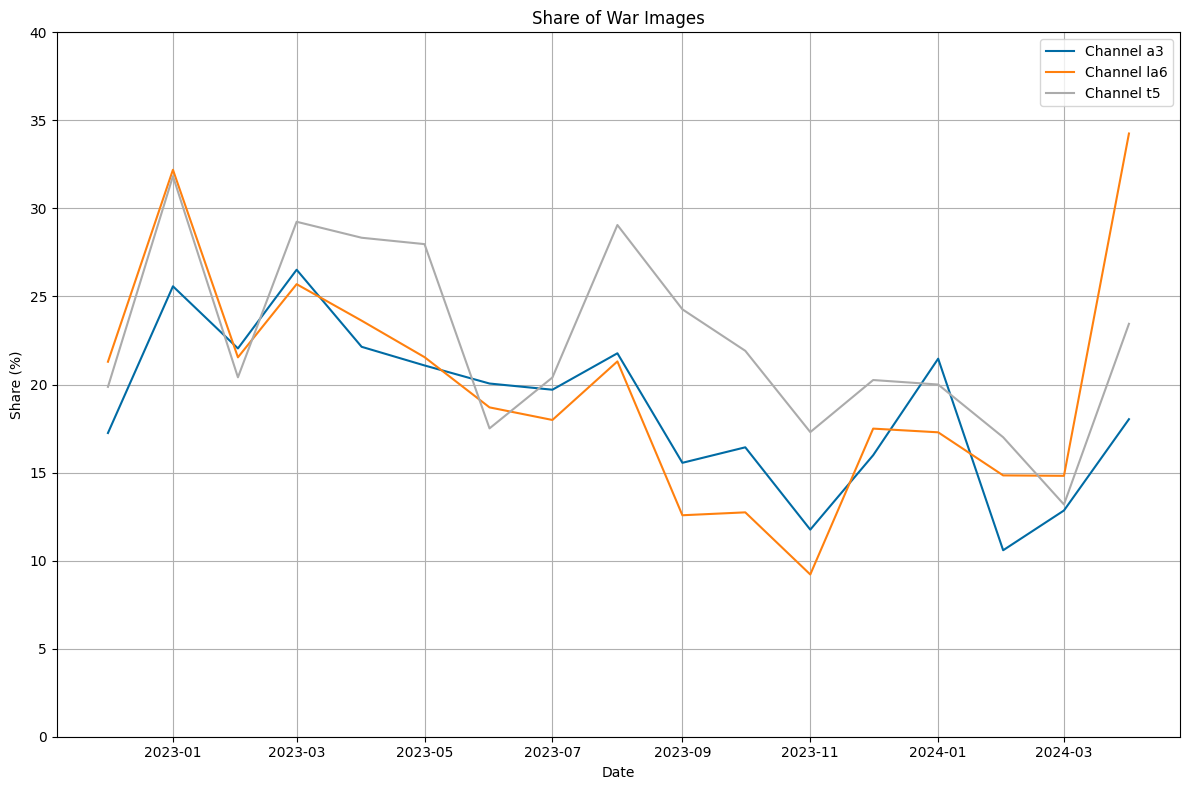

In [25]:
# Share of war images by month and channel

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(final_df['year_month'], final_df['a3_share_class_1'] * 100, label=f'Channel a3')
plt.plot(final_df['year_month'], final_df['la6_share_class_1'] * 100, label=f'Channel la6')
plt.plot(final_df['year_month'], final_df['t5_share_class_1'] * 100, label=f'Channel t5')

plt.title('Share of War Images')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.ylim(0, 40)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

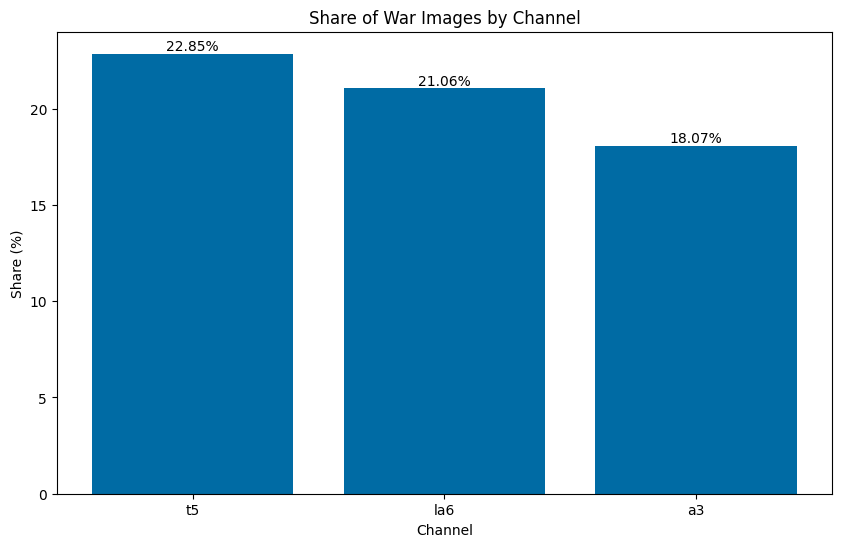

In [26]:
# Share of war images by channel
combined_share_class_1_by_channel = combined_predictions.groupby('channel')['predicted_class'].mean().reset_index()

# Sort the DataFrame by 'predicted_class' in descending order
combined_share_class_1_by_channel = combined_share_class_1_by_channel.sort_values(by='predicted_class', ascending=False)

# Convert 'share_with_ukraine' to percentages
combined_share_class_1_by_channel['predicted_class'] = combined_share_class_1_by_channel['predicted_class'] * 100

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(combined_share_class_1_by_channel['channel'], combined_share_class_1_by_channel['predicted_class'])

# Add labels and title
plt.xlabel('Channel')
plt.ylabel('Share (%)')
plt.title('Share of War Images by Channel')

# Add numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}%',
        ha='center',
        va='bottom'
    )

# Display the plot
plt.show()

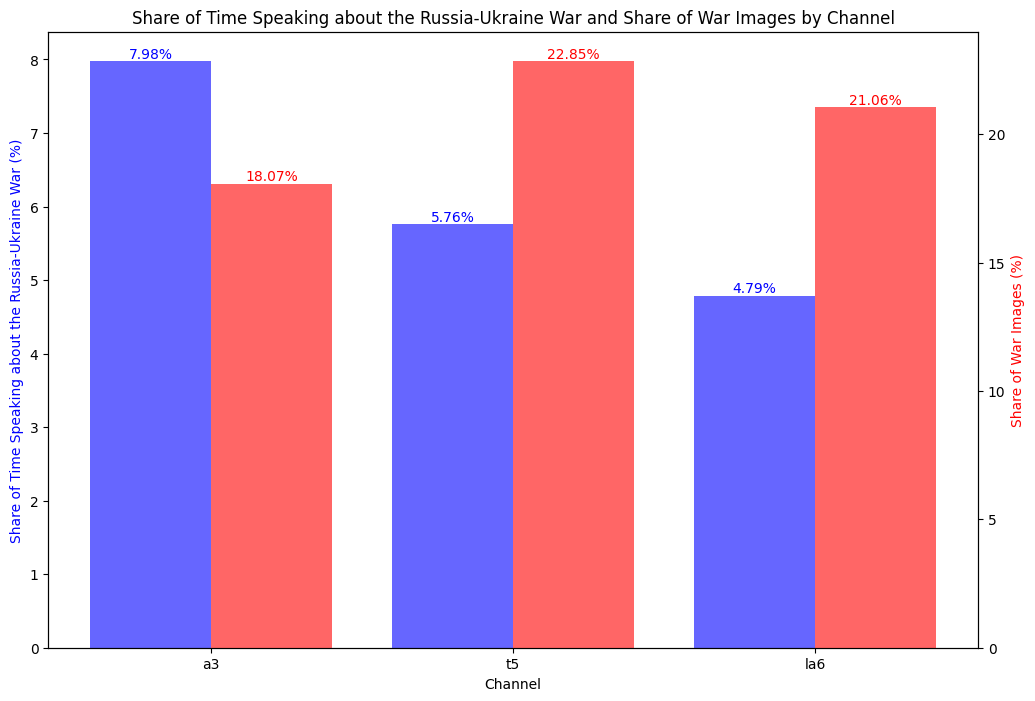

In [29]:
# Plot share of war images by channel with share of topic ukraine by channel

channels = channel_summary['channel']
combined_share_class_1_by_channel = combined_share_class_1_by_channel.set_index('channel').loc[channels].reset_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Number of bars and their width
n = len(channels)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart
bars1 = ax1.bar(r1, channel_summary['share_with_ukraine'], color='b', width=bar_width, alpha=0.6, label='Share of Time Speaking about the Russia-Ukraine War')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second bar chart
bars2 = ax2.bar(r2, combined_share_class_1_by_channel['predicted_class'], color='r', width=bar_width, alpha=0.6, label='Share of War Images')

# Add labels and title
ax1.set_xlabel('Channel')
ax1.set_ylabel('Share of Time Speaking about the Russia-Ukraine War (%)', color='b')
ax2.set_ylabel('Share of War Images (%)', color='r')
plt.title('Share of Time Speaking about the Russia-Ukraine War and Share of War Images by Channel')

# Set the position of the x ticks
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(channels)

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom', color='b')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom', color='r')

# Adding a legend
bars = [bars1, bars2]
labels = [bar[0].get_label() for bar in bars]

# Display the plot
plt.show()


In [36]:
final_df.head()

,year_month,launched,share_with_ukraine,a3_share_with_ukraine,la6_share_with_ukraine,t5_share_with_ukraine,fatalities,a3_share_class_1,la6_share_class_1,t5_share_class_1,total_share_class_1
0,2022-12-01,364.0,0.068872,0.091422,0.059908,0.058140,2174,0.172467,0.212945,0.198678,0.196723
1,2023-01-01,213.0,0.102060,0.147257,0.079872,0.079861,1187,0.255780,0.321944,0.318334,0.306667
2,2023-02-01,193.0,0.141184,0.195722,0.100925,0.137572,665,0.220494,0.215436,0.204096,0.211006
3,2023-03-01,181.0,0.090881,0.111977,0.076399,0.088000,866,0.265193,0.256988,0.292427,0.272245
4,2023-04-01,117.0,0.072224,0.091097,0.061329,0.065614,1135,0.221421,0.236270,0.283354,0.250800


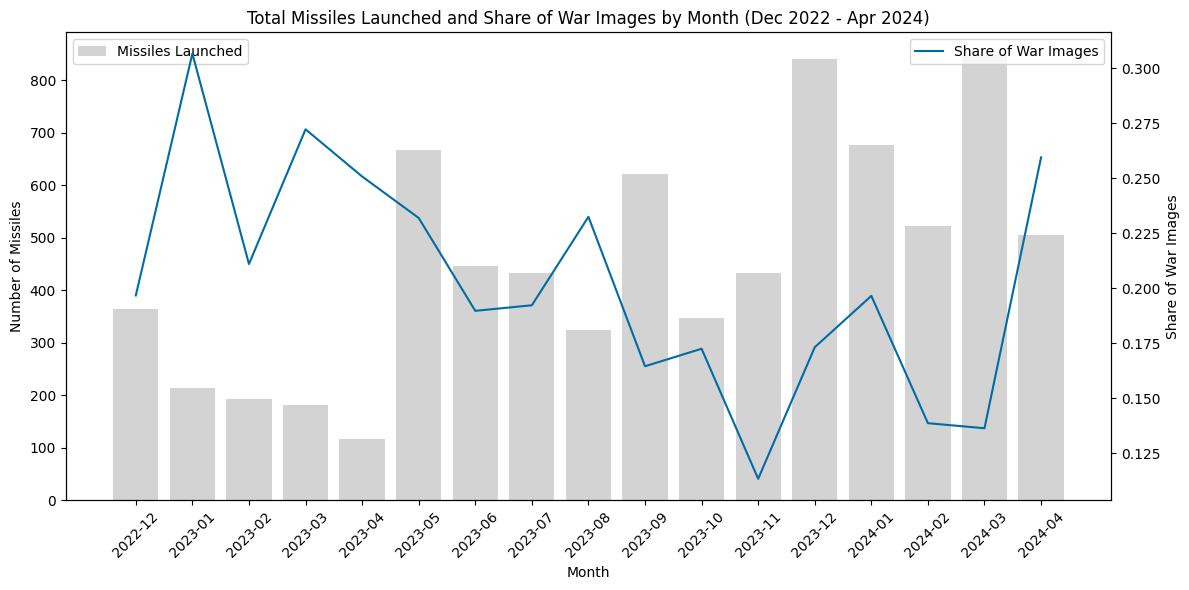

In [37]:
# Num of missiles vs total_share_class_1

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['launched'], color='lightgrey', label='Missiles Launched')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Missiles')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched and Share of War Images by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

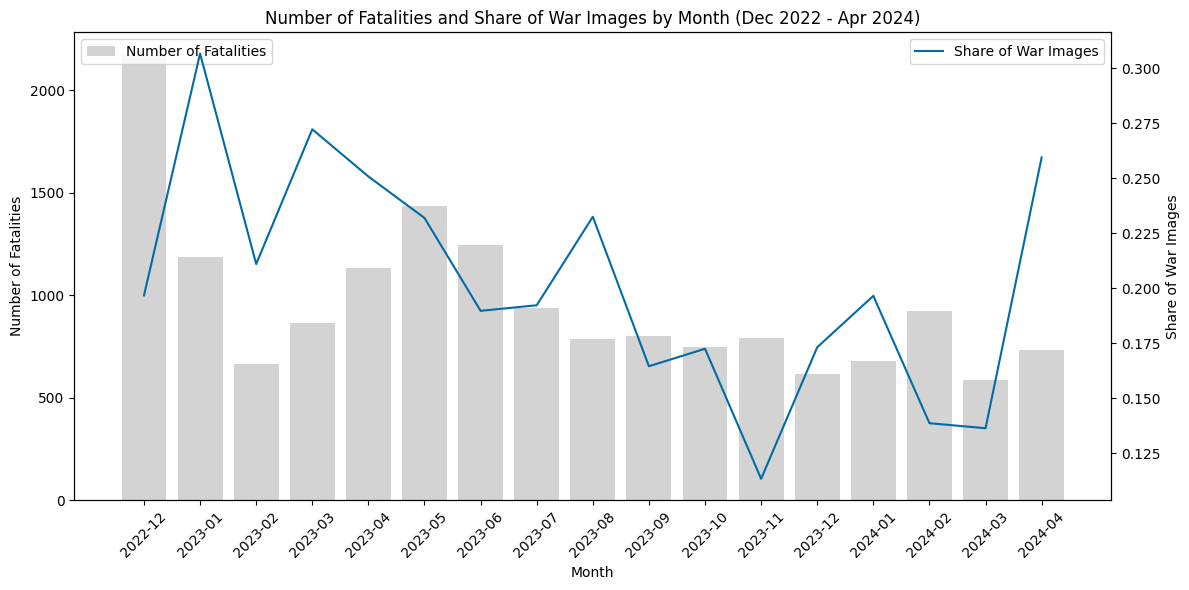

In [38]:
# Num of fatalities vs total_share_class_1

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['fatalities'], color='lightgrey', label='Number of Fatalities')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Fatalities')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')

plt.title('Number of Fatalities and Share of War Images by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

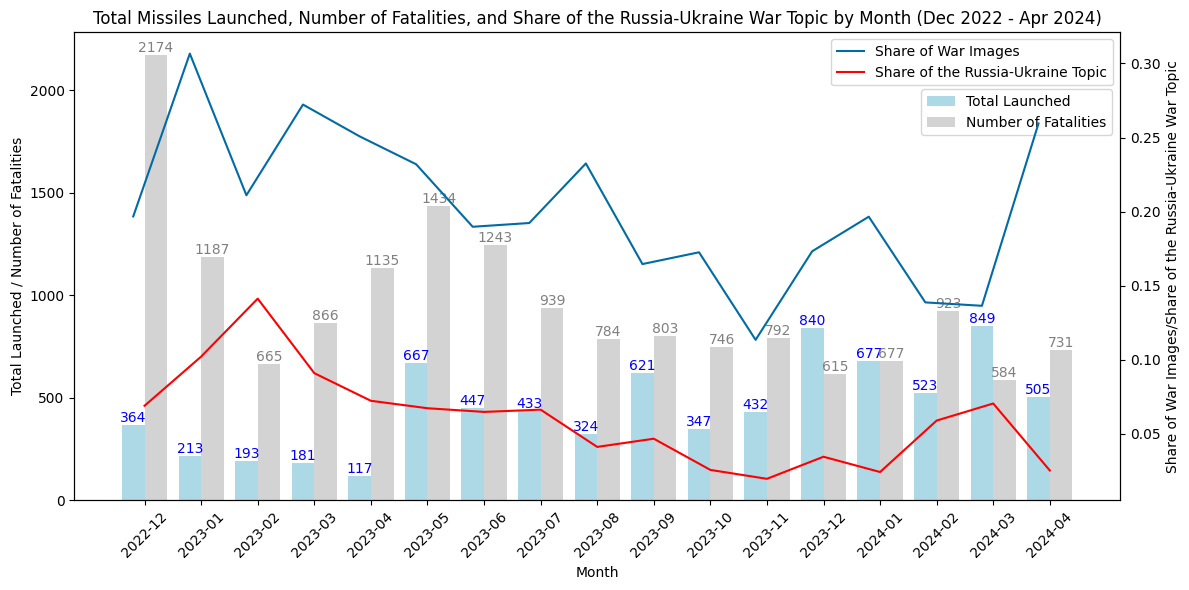

In [49]:
# Plotting number of missles and fatalities together with share of war images and share of coverage of the war

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched)
bars1 = ax1.bar(r1, df_aggregated['launched'], color='lightblue', width=bar_width, label='Total Launched')

# Plot the second bar chart (Number of Fatalities)
bars2 = ax1.bar(r2, df_aggregated['fatalities'], color='lightgrey', width=bar_width, label='Number of Fatalities')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Launched / Number of Fatalities')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.plot(r1 + bar_width / 2, df_aggregated['share_with_ukraine'], color='r', label='Share of the Russia-Ukraine Topic')
ax2.set_ylabel('Share of War Images/Share of the Russia-Ukraine War Topic')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.81, 0.78))
ax2.legend(loc='upper right')

plt.title('Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()


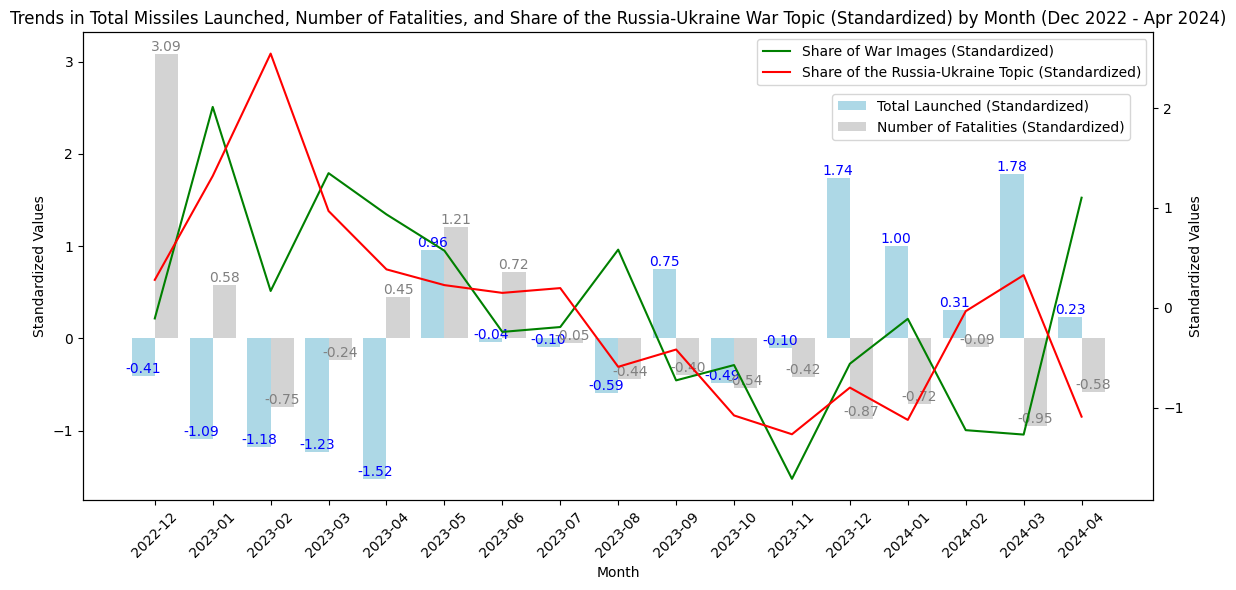

In [60]:
# Plotting standardised values of the above chart to make the trends easier to see

# Standardize the values
df_aggregated['launched_z'] = (df_aggregated['launched'] - df_aggregated['launched'].mean()) / df_aggregated['launched'].std()
df_aggregated['fatalities_z'] = (df_aggregated['fatalities'] - df_aggregated['fatalities'].mean()) / df_aggregated['fatalities'].std()
df_aggregated['share_with_ukraine_z'] = (df_aggregated['share_with_ukraine'] - df_aggregated['share_with_ukraine'].mean()) / df_aggregated['share_with_ukraine'].std()
final_df['total_share_class_1_z'] = (final_df['total_share_class_1'] - final_df['total_share_class_1'].mean()) / final_df['total_share_class_1'].std()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of bars and their width
n = len(df_aggregated)
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(n)
r2 = [x + bar_width for x in r1]

# Plot the first bar chart (Total Launched standardized)
bars1 = ax1.bar(r1, df_aggregated['launched_z'], color='lightblue', width=bar_width, label='Total Launched (Standardized)')

# Plot the second bar chart (Number of Fatalities standardized)
bars2 = ax1.bar(r2, df_aggregated['fatalities_z'], color='lightgrey', width=bar_width, label='Number of Fatalities (Standardized)')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Standardized Values')
ax1.set_xticks([r + bar_width / 2 for r in range(n)])
ax1.set_xticklabels(df_aggregated['year_month'].dt.strftime('%Y-%m'), rotation=45)

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(r1 + bar_width / 2, final_df['total_share_class_1_z'], color='g', label='Share of War Images (Standardized)')
ax2.plot(r1 + bar_width / 2, df_aggregated['share_with_ukraine_z'], color='r', label='Share of the Russia-Ukraine Topic (Standardized)')
ax2.set_ylabel('Standardized Values')

# Add numbers on top of the bars for the first bar chart
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='blue')

# Add numbers on top of the bars for the second bar chart
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='grey')

# Adding legends
bars = [bars1, bars2]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc=(0.7, 0.77))
ax2.legend(loc='upper right')

plt.title('Trends in Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic (Standardized) by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

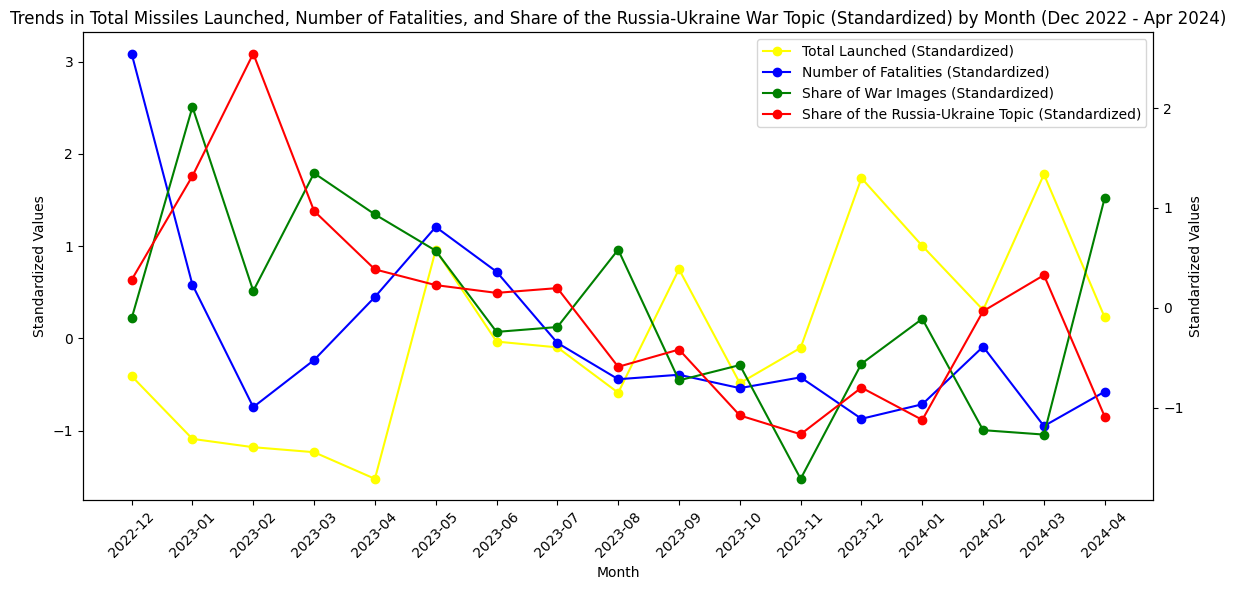

In [54]:
# Same standarised plot as above but with all lines rather than bars for real data

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of data points
n = len(df_aggregated)
months = df_aggregated['year_month'].dt.strftime('%Y-%m')

# Plot the first line chart (Total Launched standardized)
ax1.plot(months, df_aggregated['launched_z'], color='yellow', marker='o', label='Total Launched (Standardized)')

# Plot the second line chart (Number of Fatalities standardized)
ax1.plot(months, df_aggregated['fatalities_z'], color='blue', marker='o', label='Number of Fatalities (Standardized)')

# Add labels and title
ax1.set_xlabel('Month')
ax1.set_ylabel('Standardized Values')
ax1.set_xticks(np.arange(n))
ax1.set_xticklabels(months, rotation=45)

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(months, final_df['total_share_class_1_z'], color='g', marker='o', label='Share of War Images (Standardized)')
ax2.plot(months, df_aggregated['share_with_ukraine_z'], color='r', marker='o', label='Share of the Russia-Ukraine Topic (Standardized)')
ax2.set_ylabel('Standardized Values')

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Trends in Total Missiles Launched, Number of Fatalities, and Share of the Russia-Ukraine War Topic (Standardized) by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

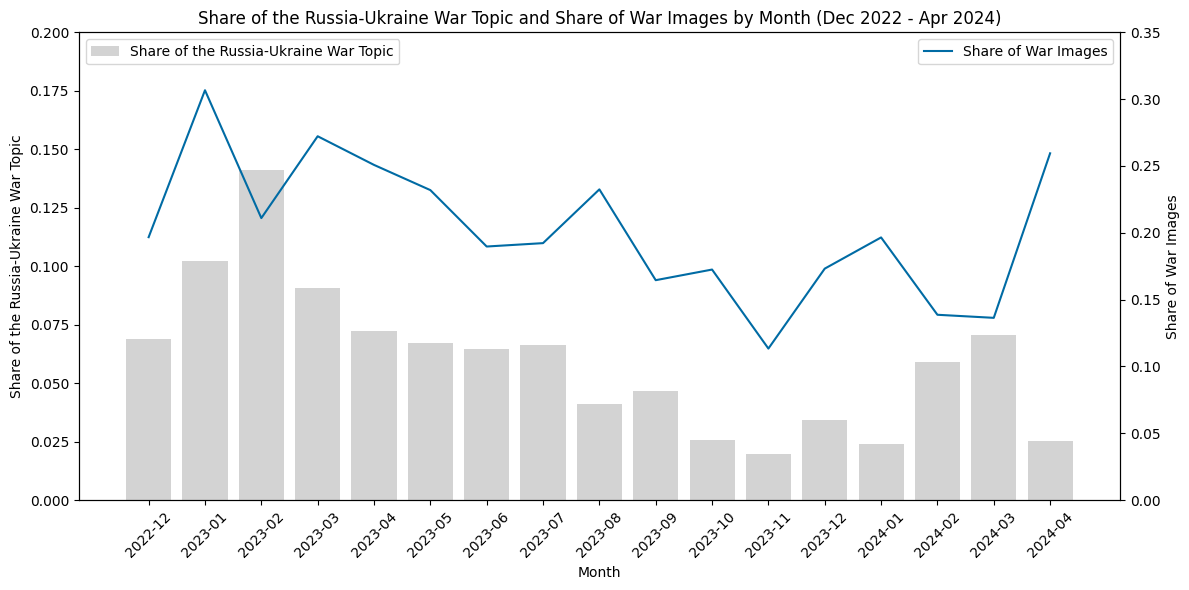

In [39]:
# Share of the Russia-Ukraine war topic vs share_class_1 (total)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['share_with_ukraine'], color='lightgrey', label='Share of the Russia-Ukraine War Topic')
ax1.set_xlabel('Month')
ax1.set_ylabel('Share of the Russia-Ukraine War Topic')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.set_ylim((0, 0.2))

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['total_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')
ax2.set_ylim((0, 0.35))

plt.title('Share of the Russia-Ukraine War Topic and Share of War Images by Month (Dec 2022 - Apr 2024)')
plt.tight_layout()
plt.show()

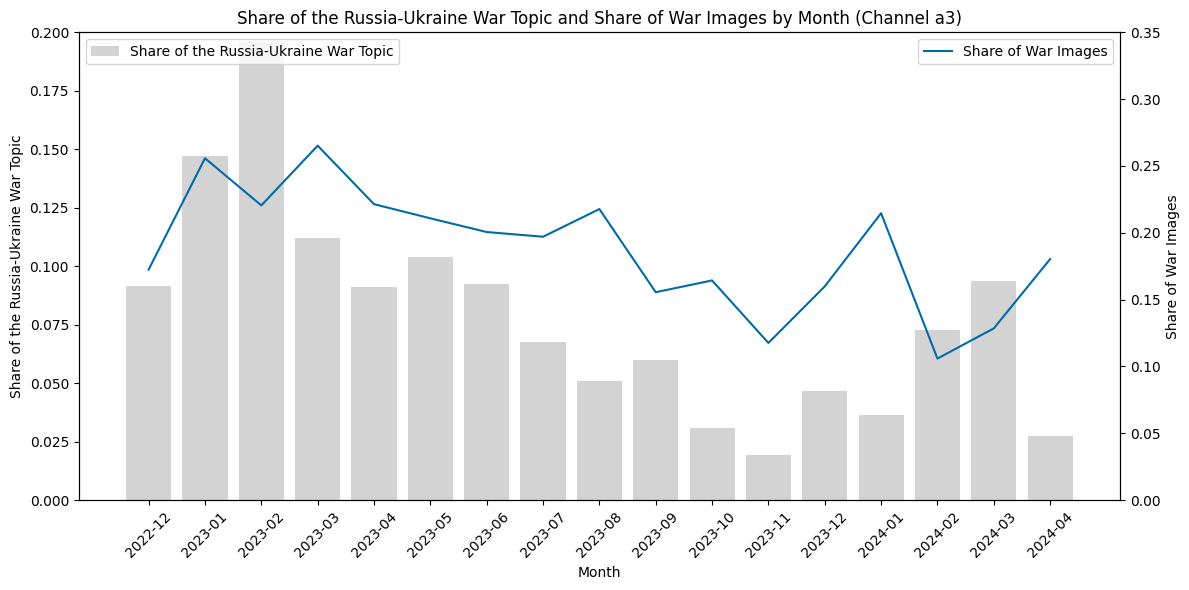

In [40]:
# Share of the Russia-Ukraine war topic vs share_class_1 for each channel (a3)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['a3_share_with_ukraine'], color='lightgrey', label='Share of the Russia-Ukraine War Topic')
ax1.set_xlabel('Month')
ax1.set_ylabel('Share of the Russia-Ukraine War Topic')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.set_ylim((0, 0.2))

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['a3_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')
ax2.set_ylim((0, 0.35))

plt.title('Share of the Russia-Ukraine War Topic and Share of War Images by Month (Channel a3)')
plt.tight_layout()
plt.show()

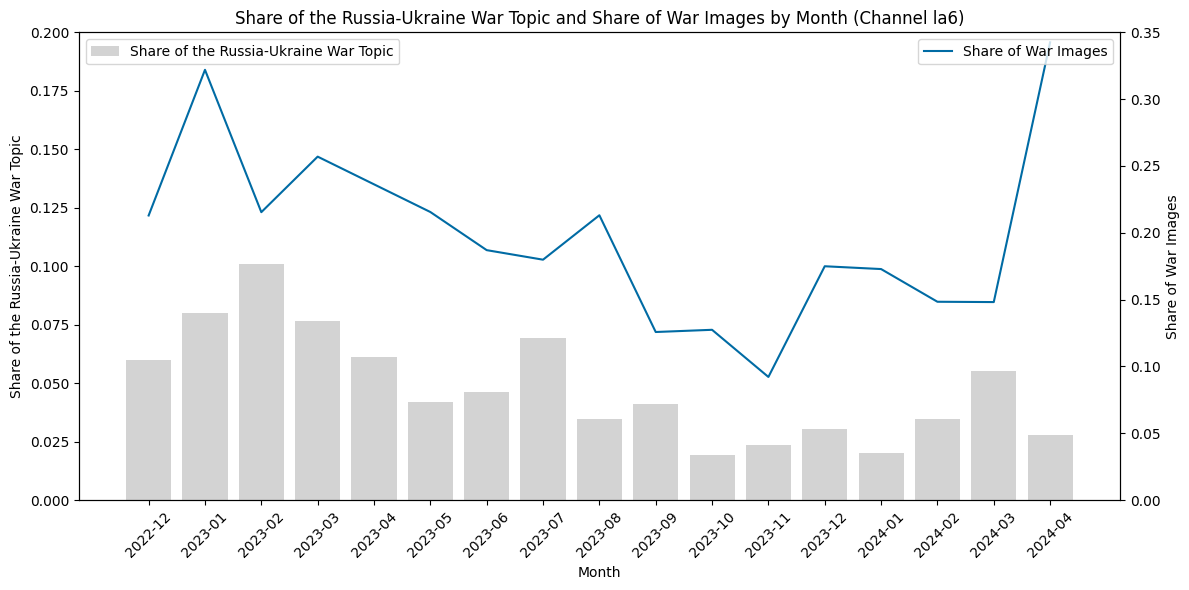

In [41]:
# Share of the Russia-Ukraine war topic vs share_class_1 for each channel (la6)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['la6_share_with_ukraine'], color='lightgrey', label='Share of the Russia-Ukraine War Topic')
ax1.set_xlabel('Month')
ax1.set_ylabel('Share of the Russia-Ukraine War Topic')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.set_ylim((0, 0.2))

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['la6_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')
ax2.set_ylim((0, 0.35))

plt.title('Share of the Russia-Ukraine War Topic and Share of War Images by Month (Channel la6)')
plt.tight_layout()
plt.show()

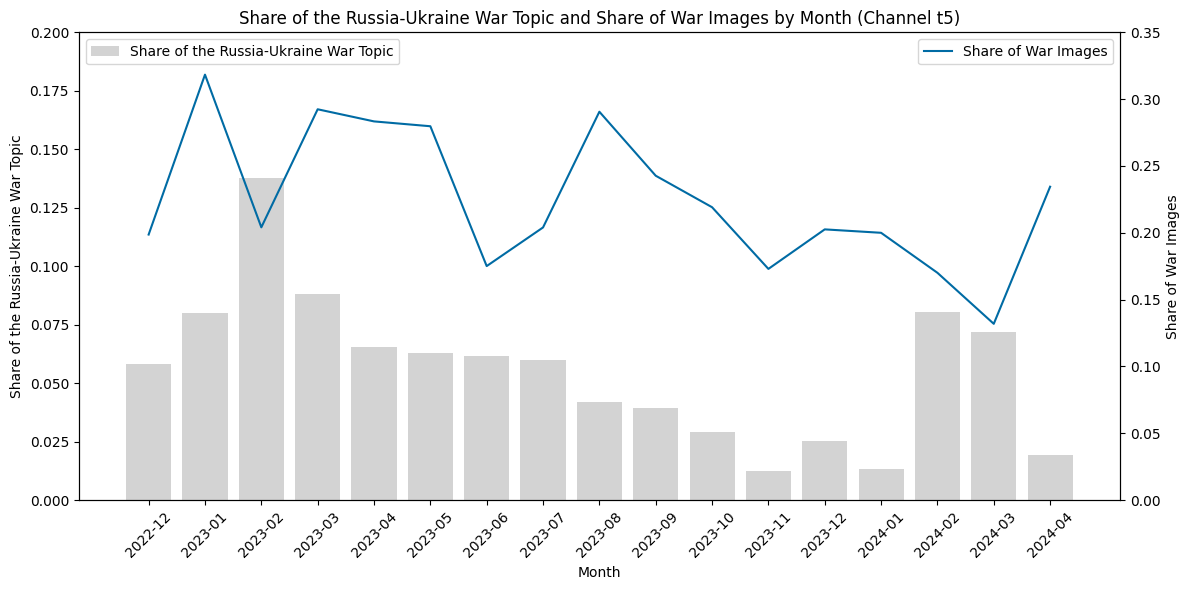

In [42]:
# Share of the Russia-Ukraine war topic vs share_class_1 for each channel (t5)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart on left axis
ax1.bar(final_df['year_month'].dt.strftime('%Y-%m'), final_df['t5_share_with_ukraine'], color='lightgrey', label='Share of the Russia-Ukraine War Topic')
ax1.set_xlabel('Month')
ax1.set_ylabel('Share of the Russia-Ukraine War Topic')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.set_ylim((0, 0.2))

# Create second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(final_df['year_month'].dt.strftime('%Y-%m'), final_df['t5_share_class_1'],  label='Share of War Images')
ax2.set_ylabel('Share of War Images')
ax2.legend(loc='upper right')
ax2.set_ylim((0, 0.35))

plt.title('Share of the Russia-Ukraine War Topic and Share of War Images by Month (Channel t5)')
plt.tight_layout()
plt.show()

## Creating confidence bands for charts

TO DO: The below needs to be updated with the actual values once angelo uploads model weights

For this we use the values from the confusion matrix displayed in the ModelEvaluation notebook. The values are as follows:

|               | Predicted Not War | Predicted War |
|---------------|--------------------|--------------------|
| **True Not War** | 1206                | 21                 |
| **True War** | 16                  | 309                 |

|               | Predicted Not War | Predicted War |
|---------------|--------------------|--------------------|
| **True Not War** | 98%                | 2%                 |
| **True War** | 5%                  | 95%                 |

In [9]:
# Import full predictions
a3_preds = pd.read_csv('predictions/atres_predictions.csv')
la6_preds = pd.read_csv('predictions/la6_predictions.csv')
t5_preds = pd.read_csv('predictions/telecinco_predictions.csv')

In [40]:
# Function which adds errors according to confusion matrix in each month - returns dict with min/max of error bar for each month
def error_dict(df, not_war_error, war_error):
    
    # Internal function to return altererd predictions based on confusion matrix
    def alter_preds(preds, not_war_error, war_error):
        preds_alter = preds.copy()
        for i, pred in enumerate(preds_alter):
            if pred==0:
                if random.random() < not_war_error:
                    preds_alter[i] = 1
            else:
                if random.random() < war_error:
                    preds_alter[i] = 0
        
        return preds_alter
    
    # Cycle through unique months and get the list of predictions for each month
    month_preds = {}
    for month in df['year_month'].unique():
        # Create subset df for each month
        df_month = df[df['year_month'] == month]
        month_preds[month] = df_month['predicted_class'].tolist()
    
    # Loop through months and generate 100 prediction lists
    altered_preds_dict = {}
    for month, preds in month_preds.items():
        altered_preds_list = []
        for _ in range(100):
            altered_preds = alter_preds(preds, not_war_error, war_error)
            altered_preds_list.append(altered_preds)
    
        altered_preds_dict[month] = altered_preds_list
        
    # Loop through all months altered lists, and find the min/max positive predictions
    min_max_dict = {}
    for month, lists in altered_preds_dict.items():
        month_max = 0
        month_min = float('inf')
        for list in lists:
            if np.mean(list) > month_max:
                month_max = np.mean(list)
            if np.mean(list) < month_min:
                month_min = np.mean(list)
        
        min_max_dict[month] = [month_min, month_max]
        
    return min_max_dict  


In [72]:
not_war_error = 0.05
war_error = 0.05

a3_min_max = error_dict(a3_preds, not_war_error, war_error)
la6_min_max = error_dict(la6_preds, not_war_error, war_error)
t5_min_max = error_dict(t5_preds, not_war_error, war_error)

In [61]:
print(a3_min_max)

{'2024-05': [0.14891179839633448, 0.16265750286368844], '2023-08': [0.2200392927308448, 0.22757039947609692], '2023-09': [0.15750081353726, 0.1672632606573381], '2022-12': [0.17493070526639976, 0.18201416692331382], '2024-04': [0.18031496062992125, 0.19448818897637796], '2023-12': [0.16203536629375676, 0.17250090220137135], '2024-02': [0.11076650420912716, 0.11829862649534781], '2023-06': [0.2034035656401945, 0.21130470016207456], '2024-03': [0.13132623929405657, 0.13859330391902414], '2023-02': [0.21995708154506438, 0.2317596566523605], '2024-01': [0.2141280353200883, 0.22461368653421634], '2023-05': [0.21328803322008305, 0.2204605511513779], '2023-11': [0.11672473867595819, 0.1332752613240418], '2023-07': [0.19799498746867167, 0.20676691729323307], '2023-01': [0.2550578034682081, 0.2651734104046243], '2023-10': [0.16368455931080186, 0.17760106030483763], '2023-04': [0.2214206437291898, 0.23529411764705882], '2023-03': [0.24861878453038674, 0.287292817679558]}


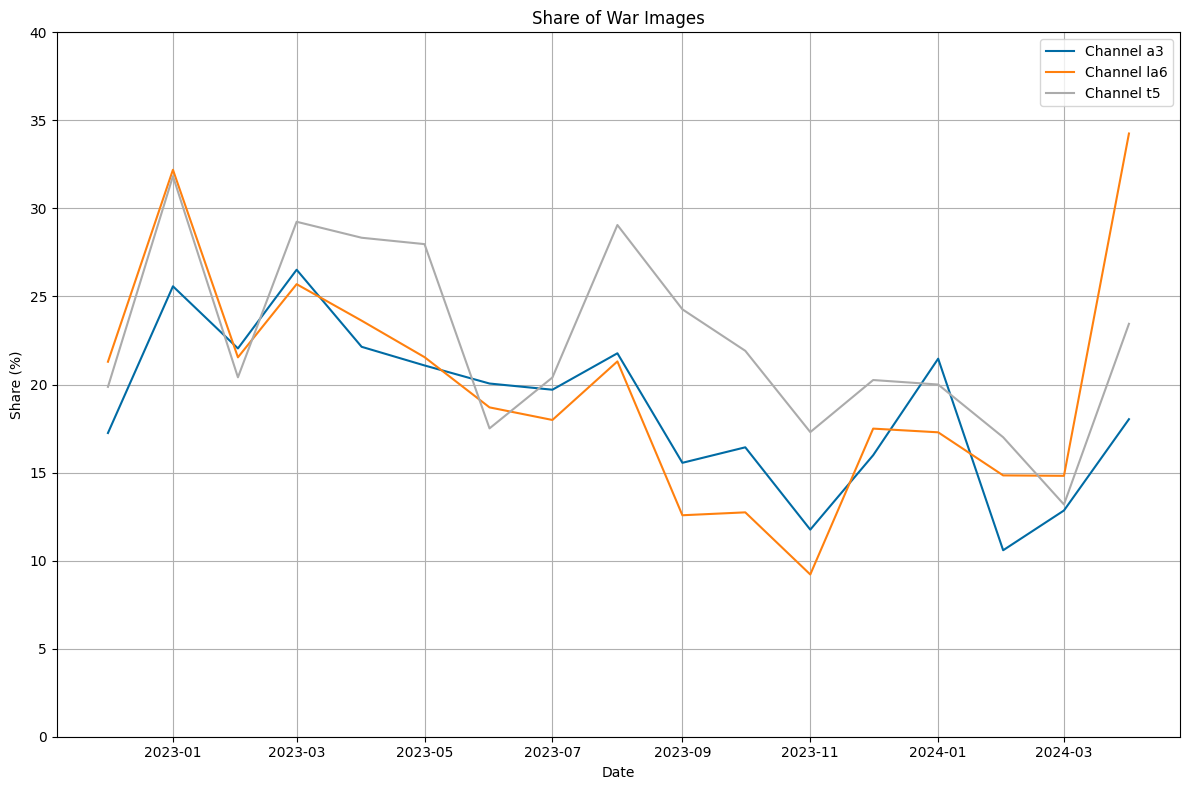

In [30]:
# Plot time series with error bars

# Share of war images by month and channel

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(final_df['year_month'], final_df['a3_share_class_1'] * 100, label=f'Channel a3')
plt.plot(final_df['year_month'], final_df['la6_share_class_1'] * 100, label=f'Channel la6')
plt.plot(final_df['year_month'], final_df['t5_share_class_1'] * 100, label=f'Channel t5')

plt.title('Share of War Images')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.ylim(0, 40)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: 'yerr' must not contain negative values

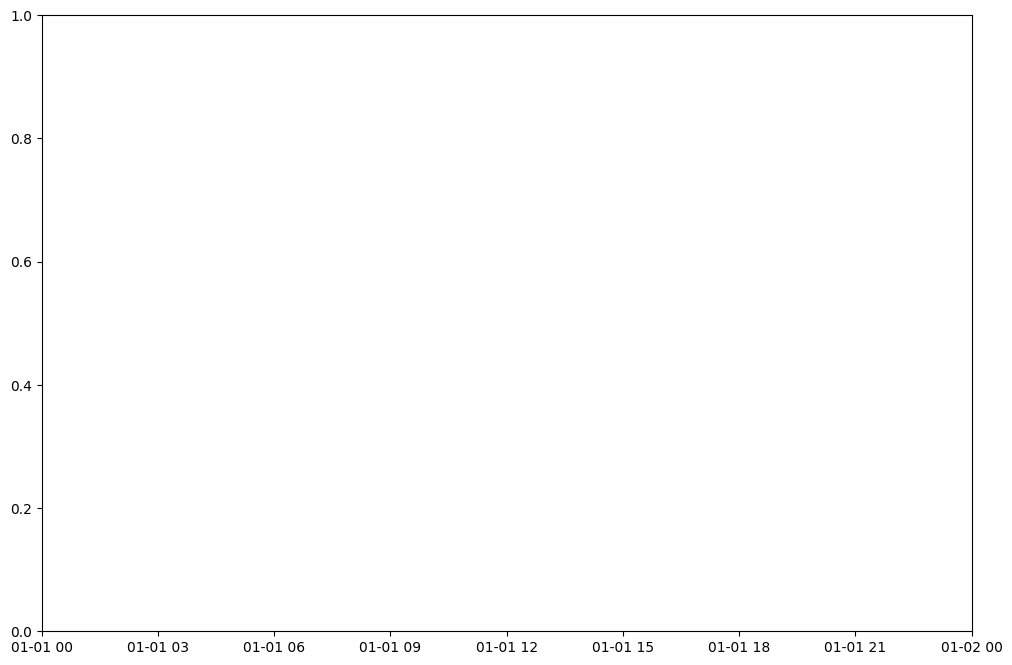

In [90]:
# Convert year_month column to datetime if not already
final_df['year_month'] = pd.to_datetime(final_df['year_month'])

# Extracting error values for a3
a3_err_lower = []
a3_err_upper = []
for date in final_df['year_month'].dt.strftime('%Y-%m'):
    if date in a3_min_max:
        lower_bound, upper_bound = a3_min_max[date]
        value = final_df.loc[final_df['year_month'].dt.strftime('%Y-%m') == date, 'a3_share_class_1'].values[0]
        a3_err_lower.append((value-lower_bound)*100)
        a3_err_upper.append((upper_bound-value)*100)
    else:
        a3_err_lower.append(0)
        a3_err_upper.append(0)

# Repeat the above steps for 'la6' and 't5' if you have their dictionaries

# Plotting
plt.figure(figsize=(12, 8))

# Plot with error bars for a3
plt.errorbar(final_df['year_month'], final_df['a3_share_class_1'] * 100, 
             yerr=[a3_err_lower, a3_err_upper], fmt='-o', label='Channel a3')

# Repeat for la6 and t5
# plt.errorbar(final_df['year_month'], final_df['la6_share_class_1'] * 100, 
#              yerr=[la6_err_lower, la6_err_upper], fmt='-o', label='Channel la6')
# plt.errorbar(final_df['year_month'], final_df['t5_share_class_1'] * 100, 
#              yerr=[t5_err_lower, t5_err_upper], fmt='-o', label='Channel t5')

plt.title('Share of War Images')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.ylim(0, 40)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
a3_err_lower

[-2.0326455189405594,
 -1.408959537572252,
 -1.609442060085839,
 0.5524861878453025,
 -1.4428412874583796,
 -2.1706304265760674,
 -2.066450567260941,
 -1.9423558897243094,
 -2.0956123117223306,
 -2.473153270419787,
 -1.9218025182239917,
 -2.35191637630662,
 -2.057019126669071,
 -1.766004415011038,
 -3.3008418254319896,
 -3.036594861147157,
 -1.2598425196850394]

In [83]:
from datetime import datetime
from collections import OrderedDict
# Parse date strings and sort the keys
sorted_keys = sorted(a3_min_max.keys(), key=lambda x: datetime.strptime(x, '%Y-%m'))

# Create an ordered dictionary
ordered_data = OrderedDict((key, a3_min_max[key]) for key in sorted_keys)

# Print the ordered dictionary
for key, value in ordered_data.items():
    print(f'{key}: {value}')

2022-12: [0.19279334770557438, 0.2128118263012011]
2023-01: [0.26986994219653176, 0.29371387283236994]
2023-02: [0.23658798283261803, 0.2607296137339056]
2023-03: [0.2596685082872928, 0.3314917127071823]
2023-04: [0.2358490566037736, 0.26082130965593786]
2023-05: [0.2325405813514534, 0.24782936957342394]
2023-06: [0.22123176661264182, 0.23683144246353321]
2023-07: [0.21647869674185463, 0.2387218045112782]
2023-08: [0.2387033398821218, 0.2540929927963327]
2023-09: [0.18027985681744224, 0.20208265538561665]
2023-10: [0.18356527501656728, 0.21206096752816433]
2023-11: [0.14111498257839722, 0.1681184668989547]
2023-12: [0.18044027426921688, 0.20245398773006135]
2024-01: [0.23233995584988962, 0.2544150110375276]
2024-02: [0.13890119627824546, 0.15396544085068675]
2024-03: [0.1588372696600052, 0.1744095509992214]
2024-04: [0.19291338582677164, 0.22440944881889763]
2024-05: [0.1729667812142039, 0.19873997709049254]


In [86]:
final_df[['year_month', 'a3_share_class_1']]

,year_month,a3_share_class_1
0,2022-12-01,0.172467
1,2023-01-01,0.255780
2,2023-02-01,0.220494
3,2023-03-01,0.265193
4,2023-04-01,0.221421
5,2023-05-01,0.210834
6,2023-06-01,0.200567
7,2023-07-01,0.197055
8,2023-08-01,0.217747
9,2023-09-01,0.155548


In [92]:
# WHY IS THE LOWER BOUND ALWAYS HIGHER???

unbal = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]

def alter_preds(preds, not_war_error, war_error):
    preds_alter = preds.copy()
    for i, pred in enumerate(preds_alter):
        if pred==0:
            if random.random() < not_war_error:
                preds_alter[i] = 1
        else:
            if random.random() < war_error:
                preds_alter[i] = 0
    
    return preds_alter

alter_unbal = alter_preds(unbal, 0.1, 0.1)


In [93]:
alter_unbal

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

### New attempt

In [94]:
# Function which adds errors according to confusion matrix in each month - returns dict with min/max of error bar for each month
def error_dict(df, not_war_error, war_error):
    
    # Internal function to return altererd predictions based on confusion matrix
    def alter_preds(preds, error, war=True):
        preds_alter = preds.copy()
        if war==True:
            for i, pred in enumerate(preds_alter):
                if pred==1:
                    if random.random() < error:
                        preds_alter[i] = 0
        else:
            for i, pred in enumerate(preds_alter):
                if pred==0:
                    if random.random() < error:
                        preds_alter[i] = 1           
            
        return preds_alter
    
    # Cycle through unique months and get the list of predictions for each month
    month_preds = {}
    for month in df['year_month'].unique():
        # Create subset df for each month
        df_month = df[df['year_month'] == month]
        month_preds[month] = df_month['predicted_class'].tolist()
    
    # Loop through months and generate 100 prediction lists for both upper anbd lower bound
    altered_preds_dict = {}
    for month, preds in month_preds.items():
        lower_preds_list = []
        upper_preds_list = []
        for _ in range(100):
            # Lower is where war turns to not_war
            lower_preds = alter_preds(preds, war_error, war=True)
            upper_preds = alter_preds(preds, not_war_error, war=False)
            lower_preds_list.append(lower_preds)
            upper_preds_list.append(upper_preds)
    
        altered_preds_dict[f'{month}_lower'] = lower_preds_list
        altered_preds_dict[f'{month}_upper'] = upper_preds_list
        
    # Loop through all months altered lists, and find the min/max for the upper and lower bound
    min_max_dict = {}
    for month_upper_or_lower, lists in altered_preds_dict.items():
        month_max = 0
        month_min = float('inf')
        for list in lists:
            if np.mean(list) > month_max:
                month_max = np.mean(list)
            if np.mean(list) < month_min:
                month_min = np.mean(list)
        
        if 'lower' in month_upper_or_lower:
            min_max_dict[month_upper_or_lower] = month_min
        elif 'upper' in month_upper_or_lower:
            min_max_dict[month_upper_or_lower] = month_max
        else:
            raise ValueError
        
    return min_max_dict  


In [110]:
not_war_error = 0.03
war_error = 0.16

a3_min_max = error_dict(a3_preds, not_war_error, war_error)
la6_min_max = error_dict(la6_preds, not_war_error, war_error)
t5_min_max = error_dict(t5_preds, not_war_error, war_error)

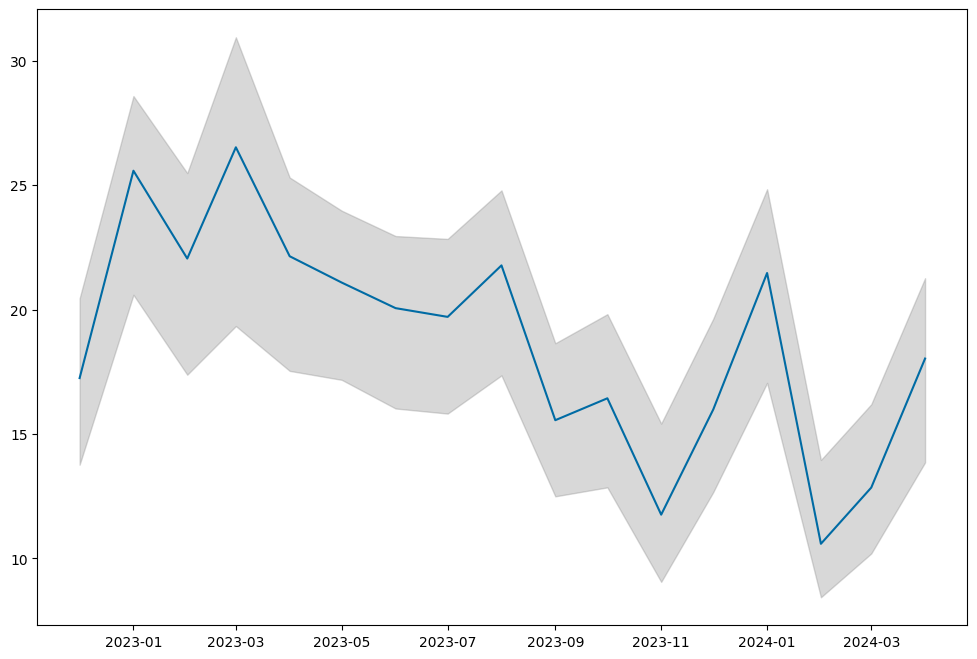

In [109]:
# Convert year_month column to datetime if not already
final_df['year_month'] = pd.to_datetime(final_df['year_month'])

# Extracting error values for a3
a3_values = final_df['a3_share_class_1'] * 100
a3_lower_bound = []
a3_upper_bound = []

for date in final_df['year_month'].dt.strftime('%Y-%m'):
    lower_key = f"{date}_lower"
    upper_key = f"{date}_upper"
    if lower_key in a3_min_max and upper_key in a3_min_max:
        lower_bound = a3_min_max[lower_key] * 100
        upper_bound = a3_min_max[upper_key] * 100
        a3_lower_bound.append(lower_bound)
        a3_upper_bound.append(upper_bound)


# Plotting
plt.figure(figsize=(12, 8))

# Plot with error bars for a3
plt.plot(final_df['year_month'], a3_values, label='Channel a3')

# Fill the area between the error bounds
plt.fill_between(final_df['year_month'], a3_lower_bound, a3_upper_bound, color='gray', alpha=0.3)

In [99]:
a3_lower_bound

[16.07637819525716,
 23.771676300578033,
 20.332618025751074,
 23.204419889502763,
 20.42175360710322,
 19.59229898074745,
 18.69935170178282,
 18.38972431077694,
 20.13752455795678,
 14.415880247315327,
 15.109343936381709,
 10.714285714285714,
 14.796102490075786,
 19.70198675496689,
 9.725299069561364,
 11.834933817804307,
 16.299212598425196]

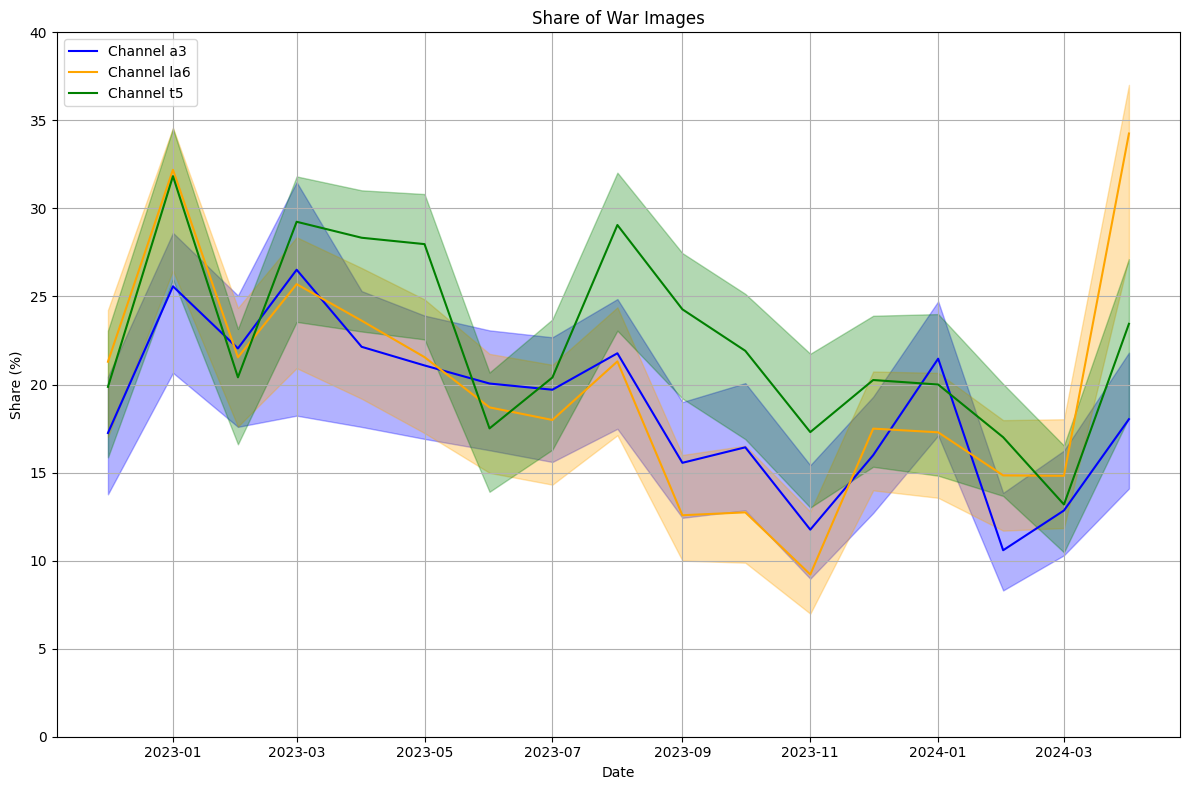

In [118]:
# Convert year_month column to datetime if not already
final_df['year_month'] = pd.to_datetime(final_df['year_month'])

# Extracting error values for a3
a3_values = final_df['a3_share_class_1'] * 100
a3_lower_bound = []
a3_upper_bound = []

for date in final_df['year_month'].dt.strftime('%Y-%m'):
    lower_key = f"{date}_lower"
    upper_key = f"{date}_upper"
    if lower_key in a3_min_max and upper_key in a3_min_max:
        lower_bound = a3_min_max[lower_key] * 100
        upper_bound = a3_min_max[upper_key] * 100
        a3_lower_bound.append(lower_bound)
        a3_upper_bound.append(upper_bound)
    else:
        # If no data is found, assume no error (just plot the line)
        a3_lower_bound.append(None)
        a3_upper_bound.append(None)

# Extracting error values for la6
la6_values = final_df['la6_share_class_1'] * 100
la6_lower_bound = []
la6_upper_bound = []

for date in final_df['year_month'].dt.strftime('%Y-%m'):
    lower_key = f"{date}_lower"
    upper_key = f"{date}_upper"
    if lower_key in la6_min_max and upper_key in la6_min_max:
        lower_bound = la6_min_max[lower_key] * 100
        upper_bound = la6_min_max[upper_key] * 100
        la6_lower_bound.append(lower_bound)
        la6_upper_bound.append(upper_bound)
    else:
        # If no data is found, assume no error (just plot the line)
        la6_lower_bound.append(None)
        la6_upper_bound.append(None)

# Extracting error values for t5
t5_values = final_df['t5_share_class_1'] * 100
t5_lower_bound = []
t5_upper_bound = []

for date in final_df['year_month'].dt.strftime('%Y-%m'):
    lower_key = f"{date}_lower"
    upper_key = f"{date}_upper"
    if lower_key in t5_min_max and upper_key in t5_min_max:
        lower_bound = t5_min_max[lower_key] * 100
        upper_bound = t5_min_max[upper_key] * 100
        t5_lower_bound.append(lower_bound)
        t5_upper_bound.append(upper_bound)
    else:
        # If no data is found, assume no error (just plot the line)
        t5_lower_bound.append(None)
        t5_upper_bound.append(None)

# Plotting
plt.figure(figsize=(12, 8))

# Plot with error bars for a3
plt.plot(final_df['year_month'], a3_values, label='Channel a3', color='blue')

# Fill the area between the error bounds for a3
plt.fill_between(final_df['year_month'], a3_lower_bound, a3_upper_bound, color='blue', alpha=0.3)

# Plot with error bars for la6
plt.plot(final_df['year_month'], la6_values, label='Channel la6', color='orange')

# Fill the area between the error bounds for la6
plt.fill_between(final_df['year_month'], la6_lower_bound, la6_upper_bound, color='orange', alpha=0.3)

# Plot with error bars for t5
plt.plot(final_df['year_month'], t5_values, label='Channel t5', color='green')

# Fill the area between the error bounds for t5
plt.fill_between(final_df['year_month'], t5_lower_bound, t5_upper_bound, color='green', alpha=0.3)

plt.title('Share of War Images')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.ylim(0, 40)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Jesus correction methodology

In [124]:
# Load labels 
labels_df = pd.read_csv('data/final_labels.csv')
labels_df.head()

,channel,image,label,choice,choice_no_lc,label_no_lc
0,atres,frame_atres_noche_2024-05-17_sec_1310.jpg,not_war,not_war,not_war,not_war
1,atres,frame_atres_noche_2024-05-17_sec_1290.jpg,not_war,not_war,not_war,not_war
2,atres,frame_atres_noche_2024-05-17_sec_1270.jpg,not_war,not_war,not_war,not_war
3,atres,frame_atres_noche_2024-05-17_sec_1250.jpg,not_war,not_war,not_war,not_war
4,atres,frame_atres_noche_2024-05-17_sec_1230.jpg,not_war,not_war,not_war,not_war


In [125]:
len(labels_df)

10339

In [130]:
labels_df.columns

Index(['channel', 'image', 'label', 'choice', 'choice_no_lc', 'label_no_lc'], dtype='object')

In [131]:
labels_df['label_no_lc'].unique()

array(['not_war', 'war'], dtype=object)

Obtain actual distribution of predictions in data

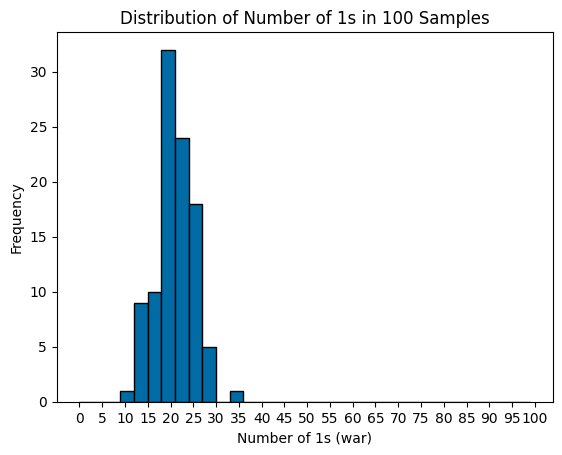

In [138]:
all_samples = []

# Loop to generate 100 lists
for _ in range(100):
    # Sample 100 random labels from the 'label_no_lc' column
    sampled_labels = labels_df['label_no_lc'].sample(n=100, replace=True)
    
    # Convert the labels to 1 for 'war' and 0 for 'not_war'
    converted_labels = sampled_labels.apply(lambda x: 1 if x == 'war' else 0)
    
    # Convert the series to a list and append it to all_samples
    label_list = converted_labels.tolist()
    all_samples.append(label_list)

# Count the number of 1's in each sample
count_of_ones = [sum(sample) for sample in all_samples]

# Plot a histogram of the counts of 1's
plt.hist(count_of_ones, bins=range(0, 101, 3), edgecolor='black')
plt.title('Distribution of Number of 1s in 100 Samples')
plt.xlabel('Number of 1s (war)')
plt.ylabel('Frequency')
plt.xticks(range(0, 101, 5))
plt.show()

Simulate predictions from the model. Each time a 1 is sampled, it remains a 1 with 84% probability. Each time a 0 is sampled, it remains a 0 with 97% probability.

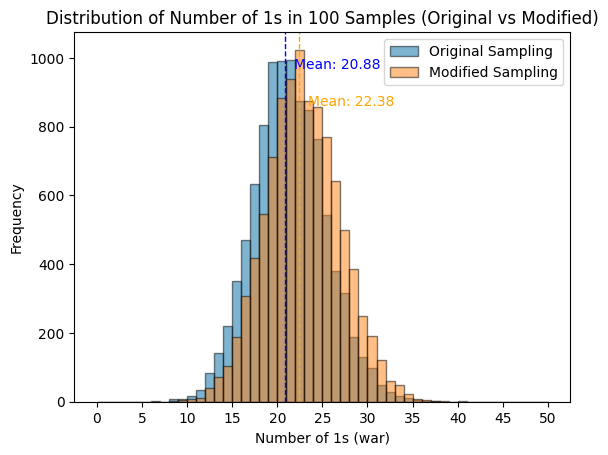

In [163]:
# Assuming you have a dataframe named 'labels_df' with the column 'label_no_lc'
# Initialize empty lists to store the 10000 lists for both original and modified sampling
original_samples = []
modified_samples = []

# Function to apply the probabilistic change
def probabilistic_change(label):
    if label == 'war':
        return 'war' if np.random.rand() < 0.88 else 'not_war'
    else:
        return 'not_war' if np.random.rand() < 0.96 else 'war'

# Loop to generate 10000 lists
for _ in range(10000):
    # Sample 100 random labels from the 'label_no_lc' column for the original samples
    original_sampled_labels = labels_df['label_no_lc'].sample(n=100, replace=True)
    
    # Apply the probabilistic change for the modified samples
    modified_sampled_labels = original_sampled_labels.apply(probabilistic_change)
    
    # Convert the labels to 1 for 'war' and 0 for 'not_war' for both original and modified samples
    original_converted_labels = original_sampled_labels.apply(lambda x: 1 if x == 'war' else 0)
    modified_converted_labels = modified_sampled_labels.apply(lambda x: 1 if x == 'war' else 0)
    
    # Convert the series to lists and append them to their respective lists
    original_samples.append(original_converted_labels.tolist())
    modified_samples.append(modified_converted_labels.tolist())

# Count the number of 1's in each sample for both original and modified samples
original_count_of_ones = [sum(sample) for sample in original_samples]
modified_count_of_ones = [sum(sample) for sample in modified_samples]

# Calculate means for both distributions
mean_original = np.mean(original_count_of_ones)
mean_modified = np.mean(modified_count_of_ones)

# Plot histograms of the counts of 1's
plt.hist(original_count_of_ones, bins=range(0, 51, 1), alpha=0.5, label='Original Sampling', edgecolor='black')
plt.hist(modified_count_of_ones, bins=range(0, 51, 1), alpha=0.5, label='Modified Sampling', edgecolor='black')

# Add vertical lines for the means
plt.axvline(mean_original, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_modified, color='orange', linestyle='dashed', linewidth=1)

# Add text for the means
plt.text(mean_original + 1, plt.ylim()[1] * 0.9, f'Mean: {mean_original:.2f}', color='blue')
plt.text(mean_modified + 1, plt.ylim()[1] * 0.8, f'Mean: {mean_modified:.2f}', color='orange')

# Add titles and labels
plt.title('Distribution of Number of 1s in 100 Samples (Original vs Modified)')
plt.xlabel('Number of 1s (war)')
plt.ylabel('Frequency')
plt.xticks(range(0, 51, 5))

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

Now simulate bias correction - after the simulations, predicted war remains war with probability 88%, wile not war remains not war with probability 95%.

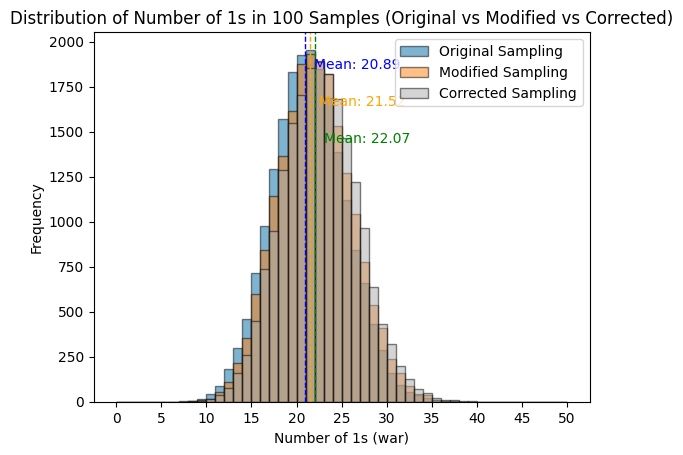

In [165]:
# Assuming you have a dataframe named 'labels_df' with the column 'label_no_lc'
# Initialize empty lists to store the lists for original, modified, and corrected samples
original_samples = []
modified_samples = []
corrected_samples = []

# Function to apply the first probabilistic change
def probabilistic_change(label):
    if label == 'war':
        return 'war' if np.random.rand() < 0.88 else 'not_war'
    else:
        return 'not_war' if np.random.rand() < 0.96 else 'war'

# Function to apply the second probabilistic change
def second_probabilistic_change(label):
    if label == 'war':
        return 'war' if np.random.rand() < 0.88 else 'not_war'
    else:
        return 'not_war' if np.random.rand() < 0.96 else 'war'

# Loop to generate 10000 lists
for _ in range(20000):
    # Sample 100 random labels from the 'label_no_lc' column for the original samples
    original_sampled_labels = labels_df['label_no_lc'].sample(n=100, replace=True)
    
    # Apply the first probabilistic change for the modified samples
    modified_sampled_labels = original_sampled_labels.apply(probabilistic_change)
    
    # Apply the second probabilistic change for the corrected samples
    corrected_sampled_labels = modified_sampled_labels.apply(second_probabilistic_change)
    
    # Convert the labels to 1 for 'war' and 0 for 'not_war' for all samples
    original_converted_labels = original_sampled_labels.apply(lambda x: 1 if x == 'war' else 0)
    modified_converted_labels = modified_sampled_labels.apply(lambda x: 1 if x == 'war' else 0)
    corrected_converted_labels = corrected_sampled_labels.apply(lambda x: 1 if x == 'war' else 0)
    
    # Convert the series to lists and append them to their respective lists
    original_samples.append(original_converted_labels.tolist())
    modified_samples.append(modified_converted_labels.tolist())
    corrected_samples.append(corrected_converted_labels.tolist())

# Count the number of 1's in each sample for all samples
original_count_of_ones = [sum(sample) for sample in original_samples]
modified_count_of_ones = [sum(sample) for sample in modified_samples]
corrected_count_of_ones = [sum(sample) for sample in corrected_samples]

# Calculate means for all distributions
mean_original = np.mean(original_count_of_ones)
mean_modified = np.mean(modified_count_of_ones)
mean_corrected = np.mean(corrected_count_of_ones)

# Plot histograms of the counts of 1's
plt.hist(original_count_of_ones, bins=range(0, 51, 1), alpha=0.5, label='Original Sampling', edgecolor='black')
plt.hist(modified_count_of_ones, bins=range(0, 51, 1), alpha=0.5, label='Modified Sampling', edgecolor='black')
plt.hist(corrected_count_of_ones, bins=range(0, 51, 1), alpha=0.5, label='Corrected Sampling', edgecolor='black')

# Add vertical lines for the means
plt.axvline(mean_original, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_modified, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(mean_corrected, color='green', linestyle='dashed', linewidth=1)

# Add text for the means
plt.text(mean_original + 1, plt.ylim()[1] * 0.9, f'Mean: {mean_original:.2f}', color='blue')
plt.text(mean_modified + 1, plt.ylim()[1] * 0.8, f'Mean: {mean_modified:.2f}', color='orange')
plt.text(mean_corrected + 1, plt.ylim()[1] * 0.7, f'Mean: {mean_corrected:.2f}', color='green')

# Add titles and labels
plt.title('Distribution of Number of 1s in 100 Samples (Original vs Modified vs Corrected)')
plt.xlabel('Number of 1s (war)')
plt.ylabel('Frequency')
plt.xticks(range(0, 51, 5))

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()